In [21]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
import time

load_dotenv()

True

In [29]:
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    sslmode=os.getenv("DB_SSLMODE")
)

df = pd.read_sql("SELECT * FROM merged_stocks_new", conn)

df.info()

# Execute a query to get PYPL data for a specific date range
pypl_query = """
        SELECT * FROM merged_stocks_new 
        WHERE stock_symbol = 'PYPL'
         AND date >= '2023-03-25' AND date <= '2023-03-31' ORDER BY date
"""

pypl_df = pd.read_sql(pypl_query, conn)
print(f"Retrieved {len(pypl_df)} rows of PYPL data")


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_14083/167836390.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM merged_stocks_new", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15274 entries, 0 to 15273
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               15274 non-null  object 
 1   stock_symbol       15274 non-null  object 
 2   open_price         15274 non-null  float64
 3   high_price         15274 non-null  float64
 4   low_price          15274 non-null  float64
 5   close_price        15274 non-null  float64
 6   adj_close          15274 non-null  float64
 7   volume             15274 non-null  int64  
 8   daily_sentiment    15274 non-null  float64
 9   article_count      15274 non-null  int64  
 10  sentiment_std      15274 non-null  float64
 11  positive_ratio     15274 non-null  float64
 12  negative_ratio     15274 non-null  float64
 13  neutral_ratio      15274 non-null  float64
 14  sentiment_median   15274 non-null  float64
 15  sentiment_min      15274 non-null  float64
 16  sentiment_max      152

/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_14083/167836390.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pypl_df = pd.read_sql(pypl_query, conn)


# EDA

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.head()

date stock_symbol  open_price  high_price   low_price  close_price  \
0 2019-01-02         ADBE  219.910004  226.169998  219.000000   224.570007   
1 2019-01-03         ADBE  220.880005  223.630005  215.149994   215.699997   
2 2019-01-04         ADBE  219.839996  227.649994  217.479996   226.190002   
3 2019-01-06         ADBE  219.839996  227.649994  217.479996   226.190002   
4 2019-01-07         ADBE  229.949997  232.600006  227.289993   229.259995   

    adj_close   volume  daily_sentiment  article_count  ...  sentiment_median  \
0  224.570007  2784100         0.352685              1  ...          0.352685   
1  215.699997  3663500         0.000000              1  ...          0.000000   
2  226.190002  4043400         0.000000              0  ...          0.000000   
3  226.190002  4043400         0.177290              1  ...          0.177290   
4  229.259995  3638500         0.000000              0  ...          0.000000   

   sentiment_min  sentiment_max  sentiment_range        gdp   real_gdp  \
0       0.352685       0.352685              0.0  20917.867  20304.874   
1       0.000000       0.000000              0.0  20917.867  20304.874   
2       0.000000       0.000000              0.0  20917.867  20304.874   
3       0.177290       0.177290              0.0  20917.867  20304.874   
4       0.000000       0.000000              0.0  20917.867  20304.874   

   unemployment_rate      cpi  fed_funds_rate    sp500  
0                3.9  252.767             2.4  2510.03  
1                3.9  252.767             2.4  2447.89  
2                3.9  252.767             2.4  2531.94  
3                3.9  252.767             2.4  2531.94  
4                3.9  252.767             2.4  2549.69  

[5 rows x 24 columns]

### GOOG 

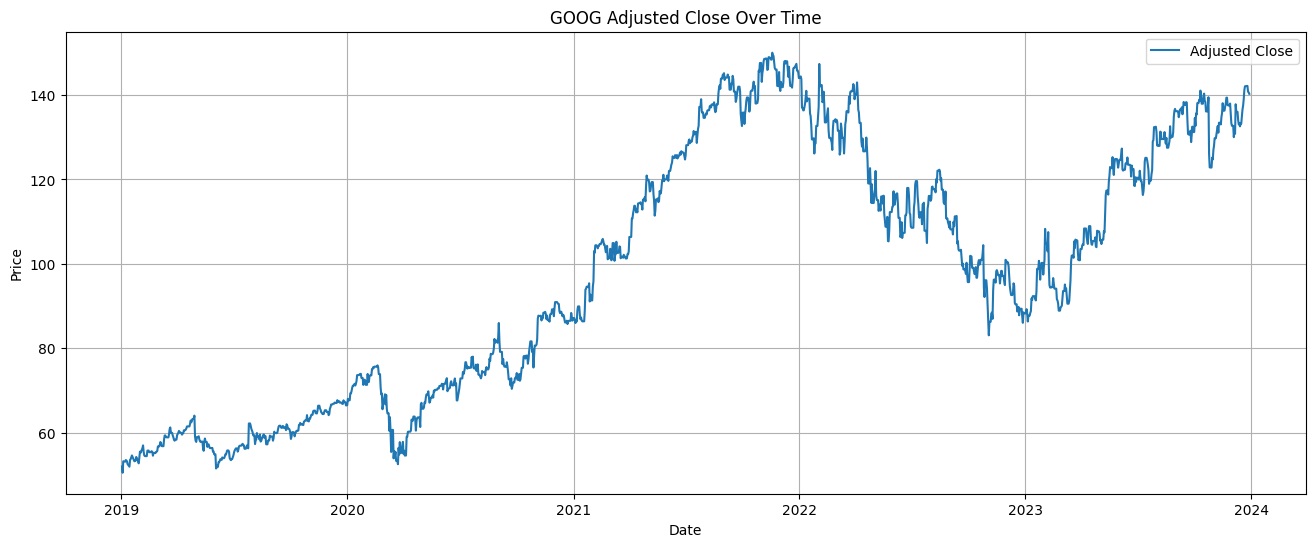

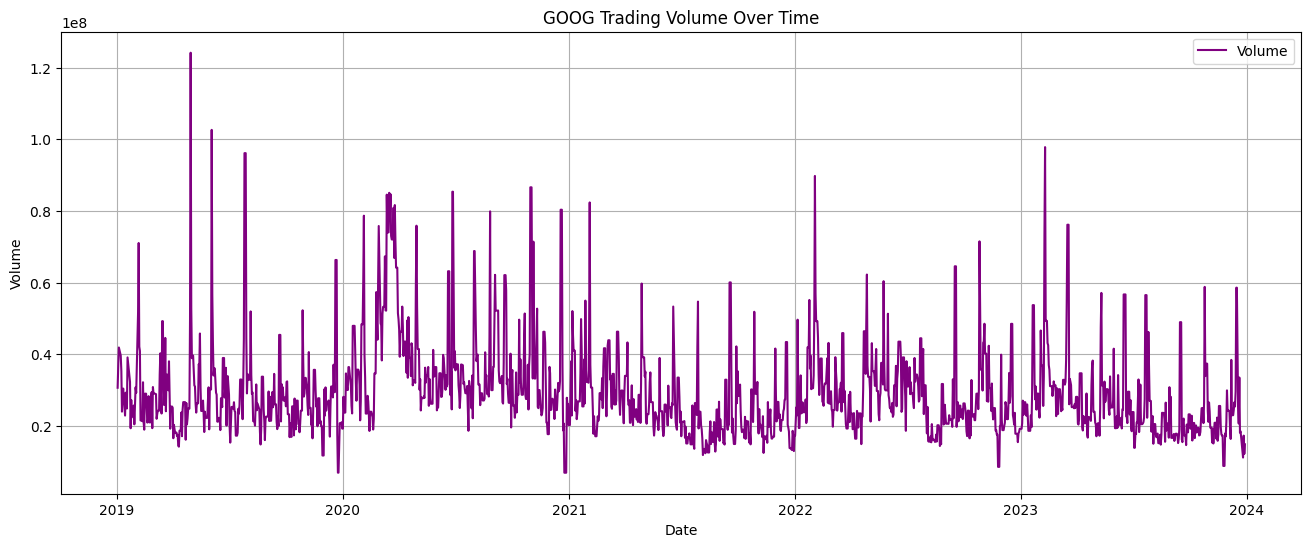

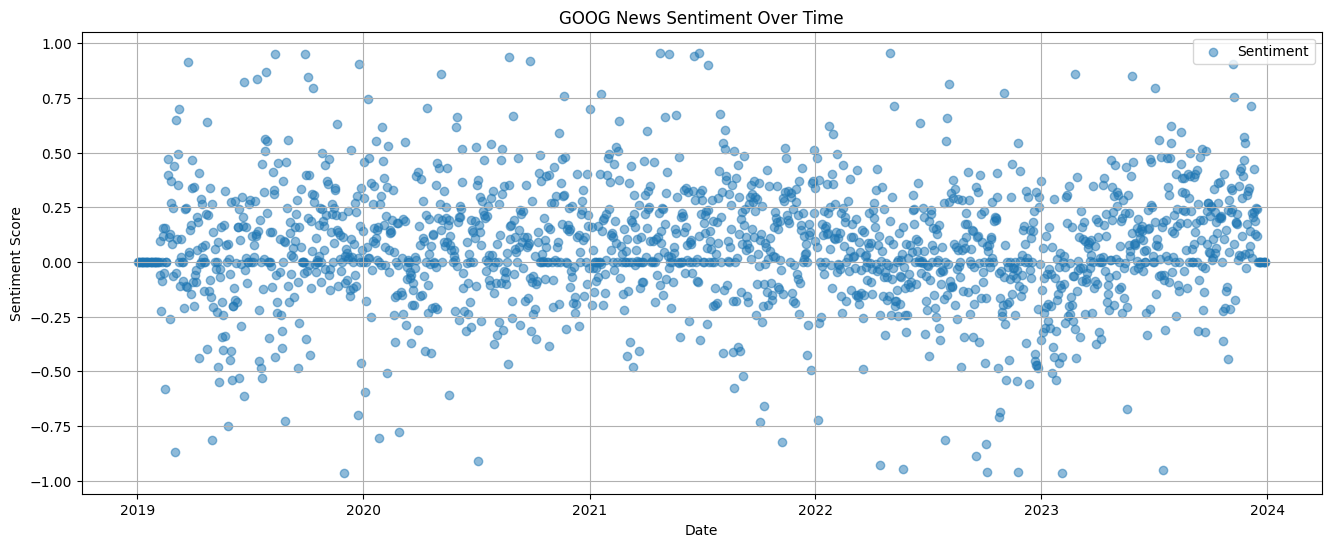

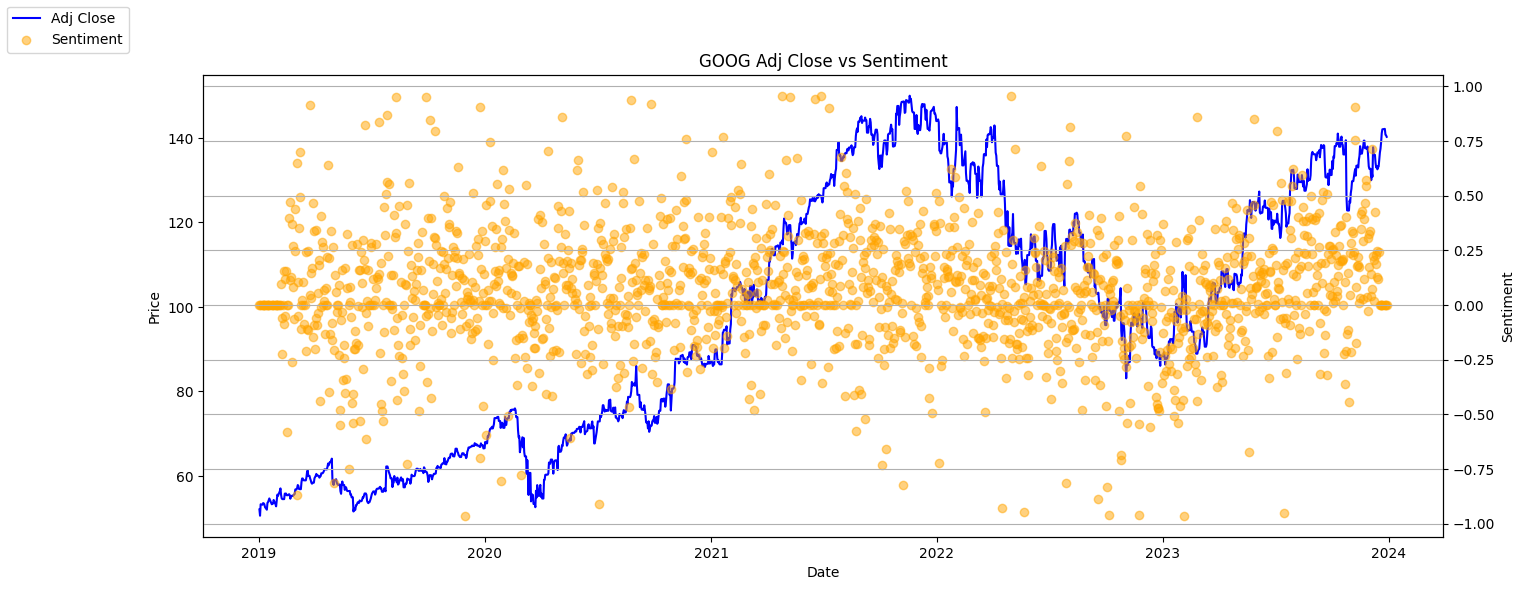

In [4]:
goog_df = df[(df['stock_symbol'] == 'GOOG')].drop(['open_price', 'high_price', 'low_price', 'close_price', 'gdp', 'sp500', 'sentiment_min', 'sentiment_median', 'sentiment_max', 'sentiment_range'], axis=1).copy()

goog_df.sort_values('date', inplace=True)
goog_df.reset_index(drop=True, inplace=True)
goog_df.set_index('date', inplace=True)

# === 1. Time Series Plots ===
plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close'], label='Adjusted Close')
plt.title('GOOG Adjusted Close Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(goog_df['volume'], color='purple', label='Volume')
plt.title('GOOG Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.scatter(goog_df.index, goog_df['daily_sentiment'], label='Sentiment', alpha=0.5)
plt.title('GOOG News Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# Overlay Sentiment and Price
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
ax1.plot(goog_df['adj_close'], label='Adj Close', color='blue')
ax2.scatter(goog_df.index, goog_df['daily_sentiment'], label='Sentiment', color='orange', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Sentiment')
plt.title("GOOG Adj Close vs Sentiment")
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_14083/4077859632.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_ranges = pd.date_range(start=goog_2020.index.min(),


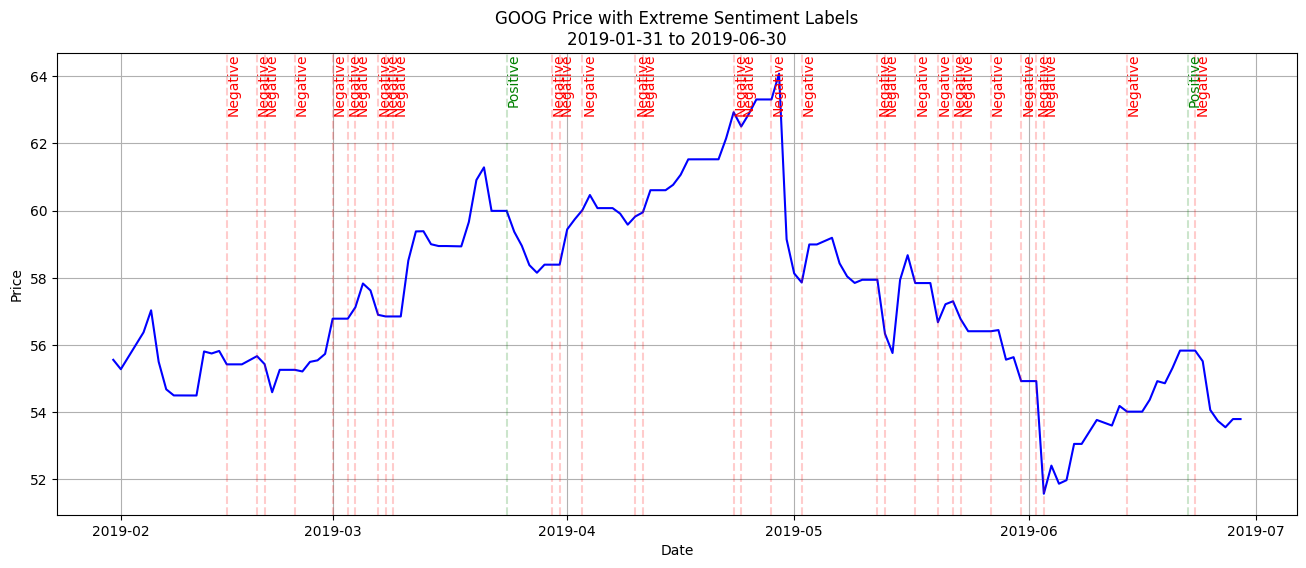

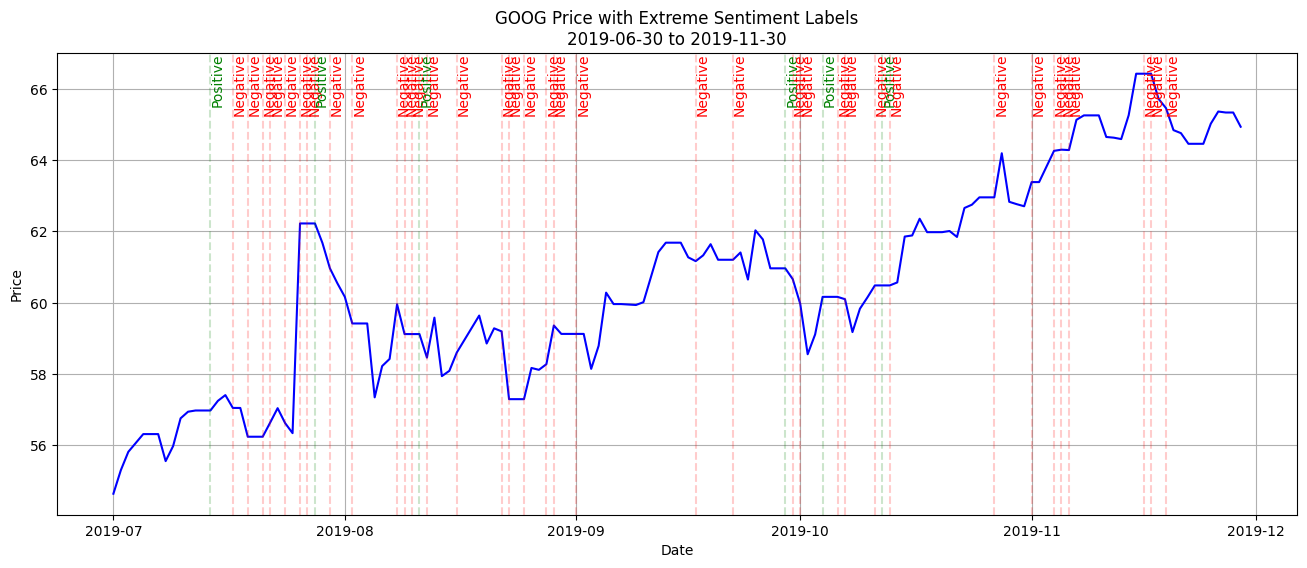

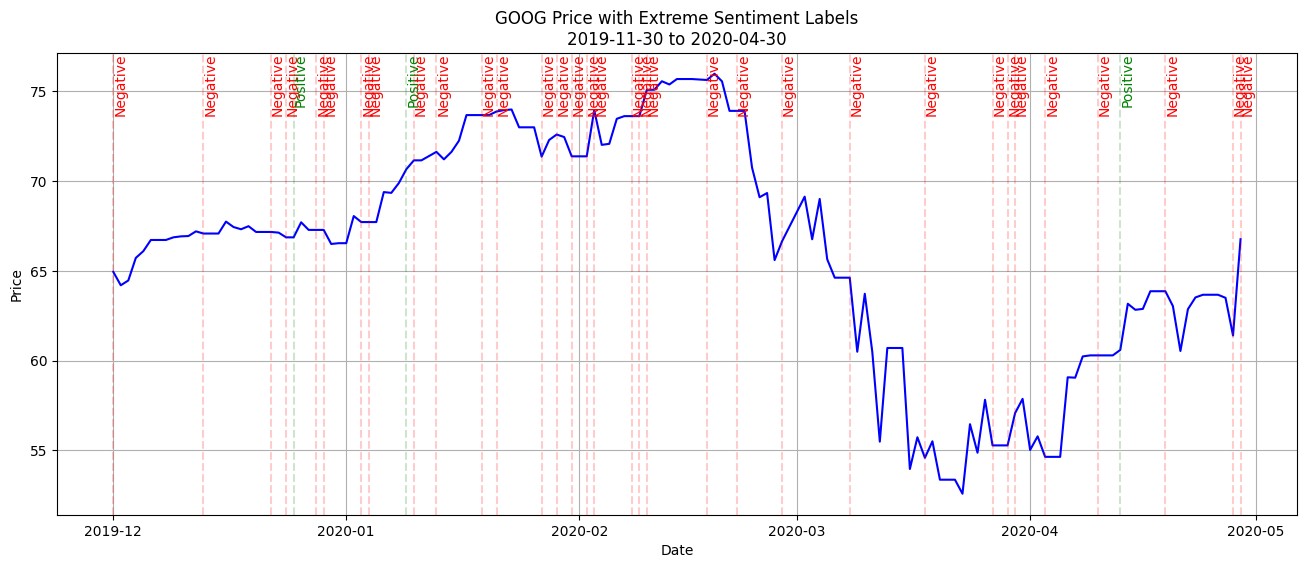

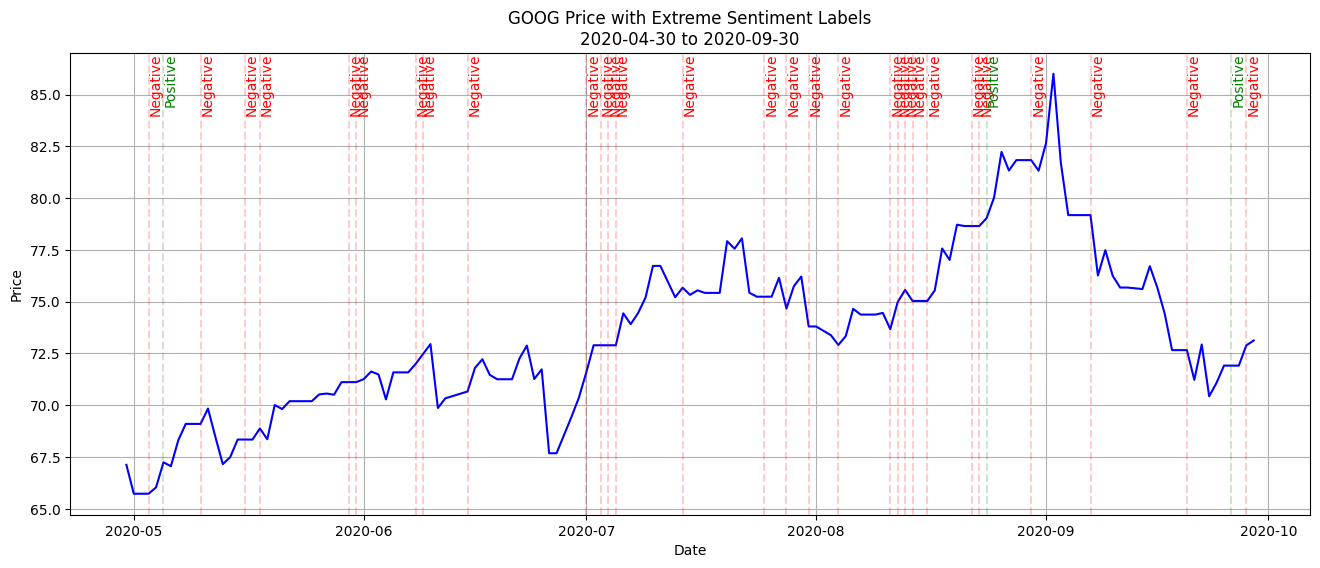

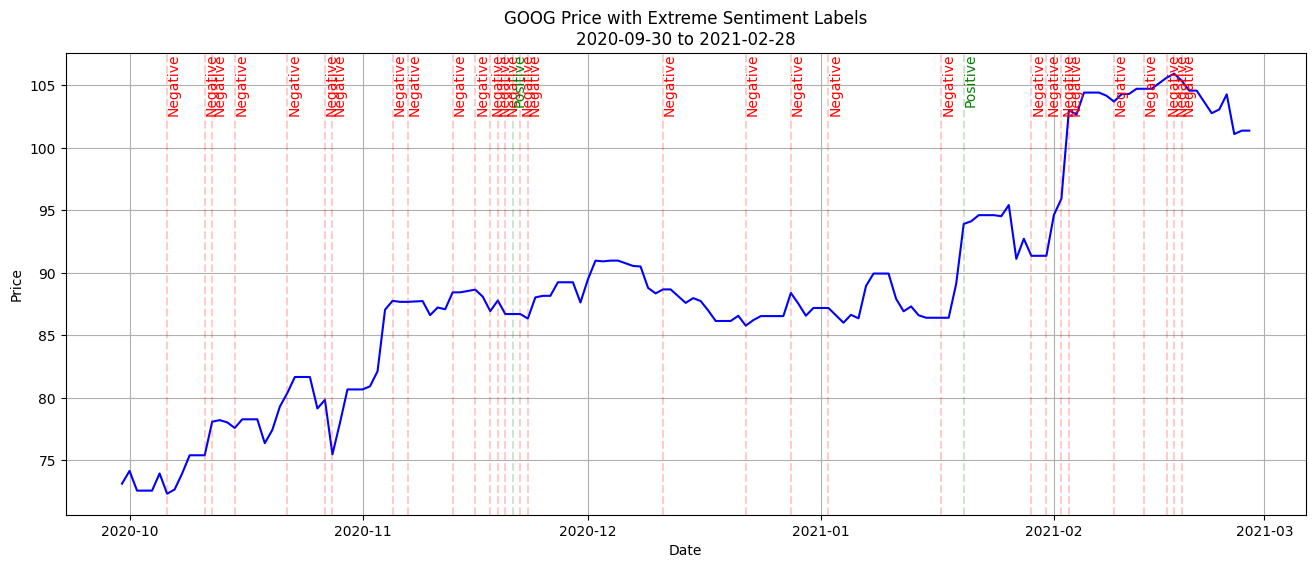

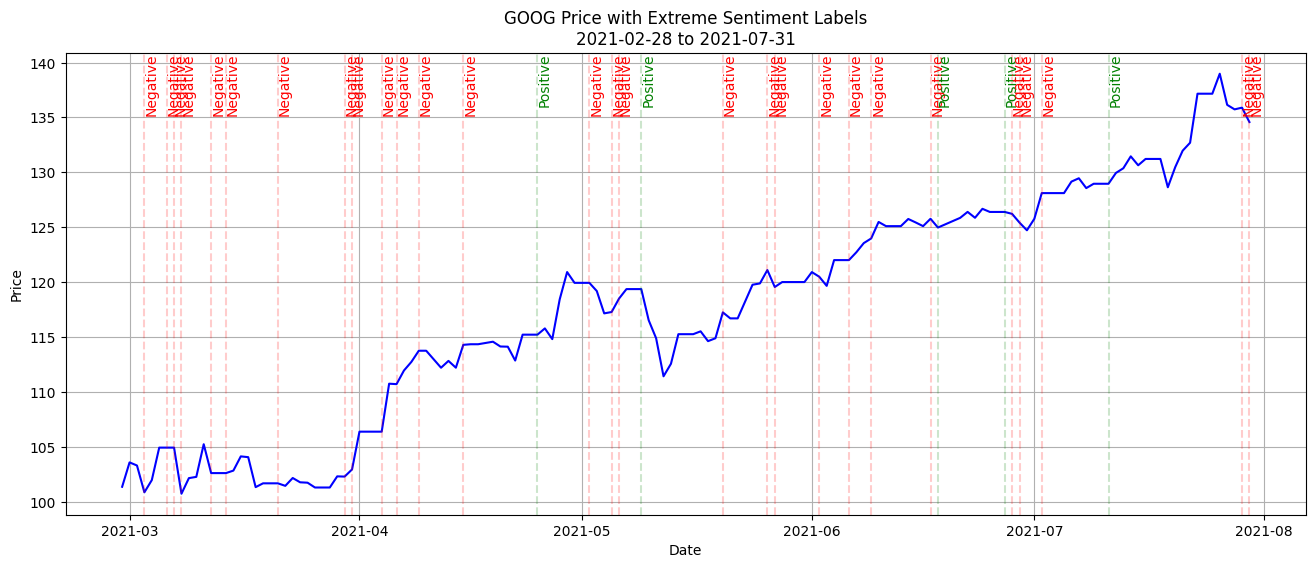

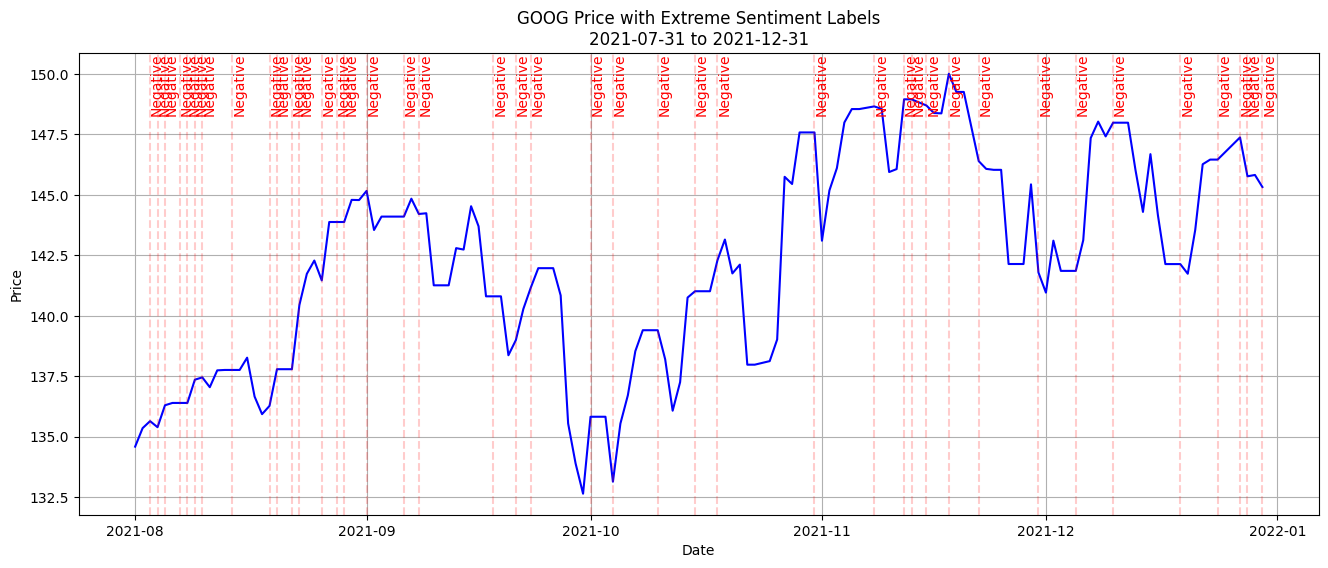

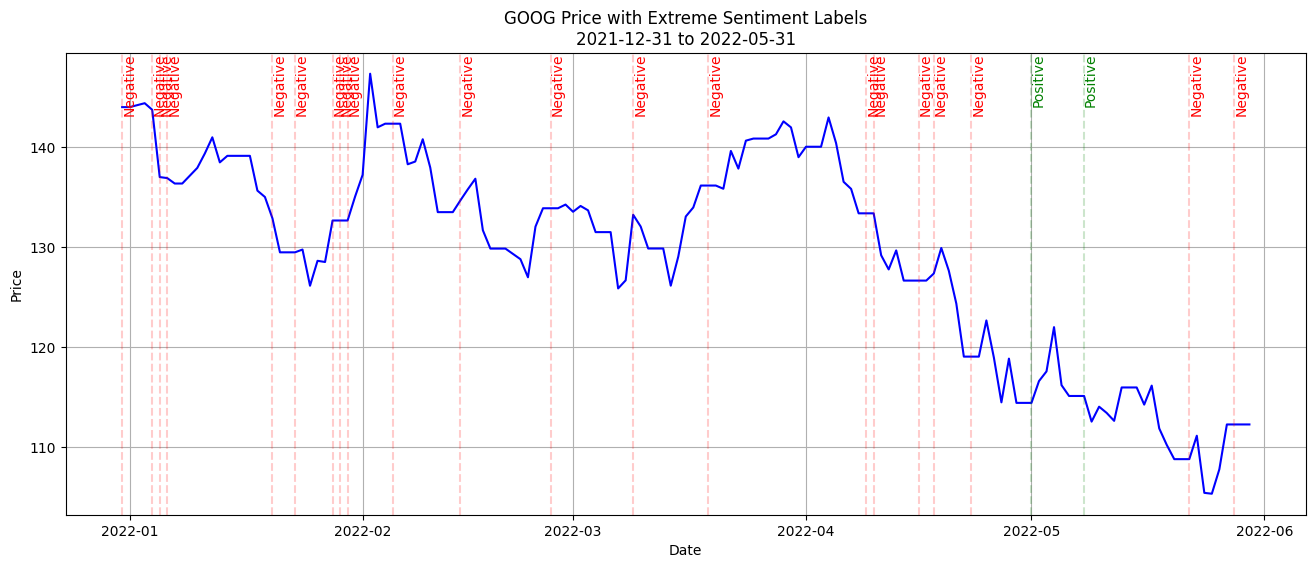

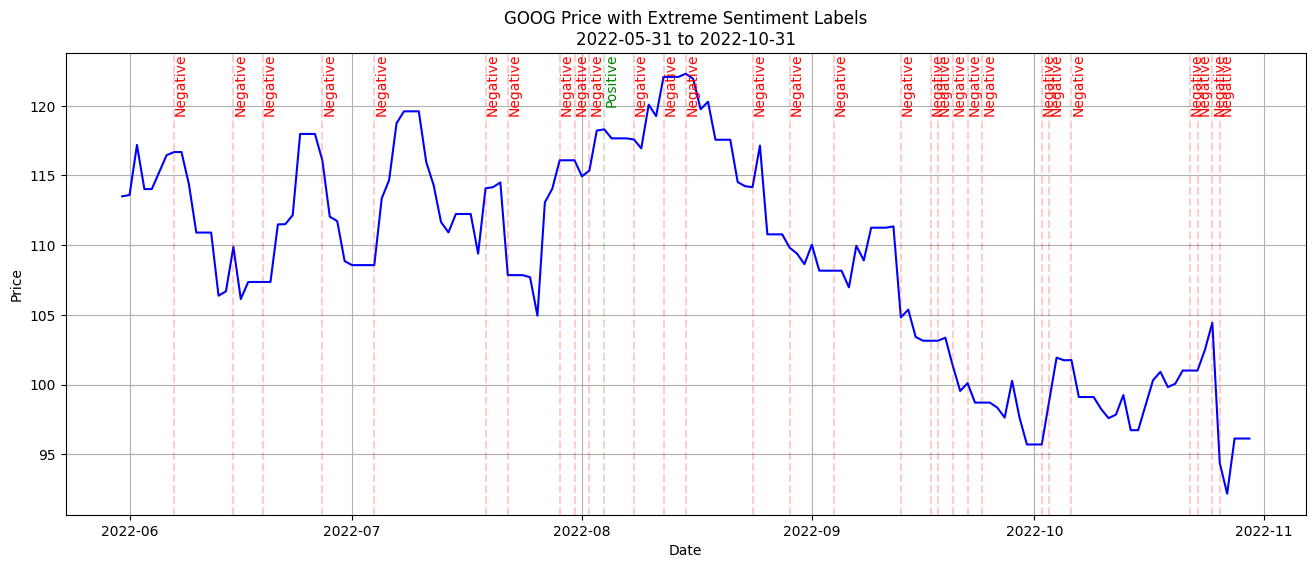

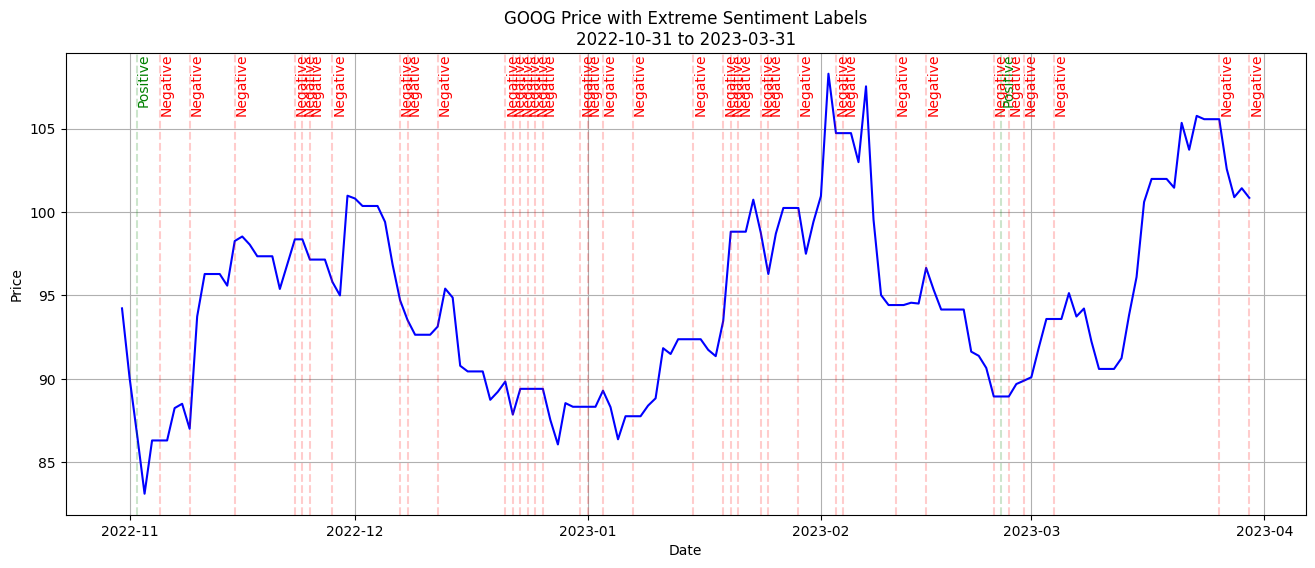

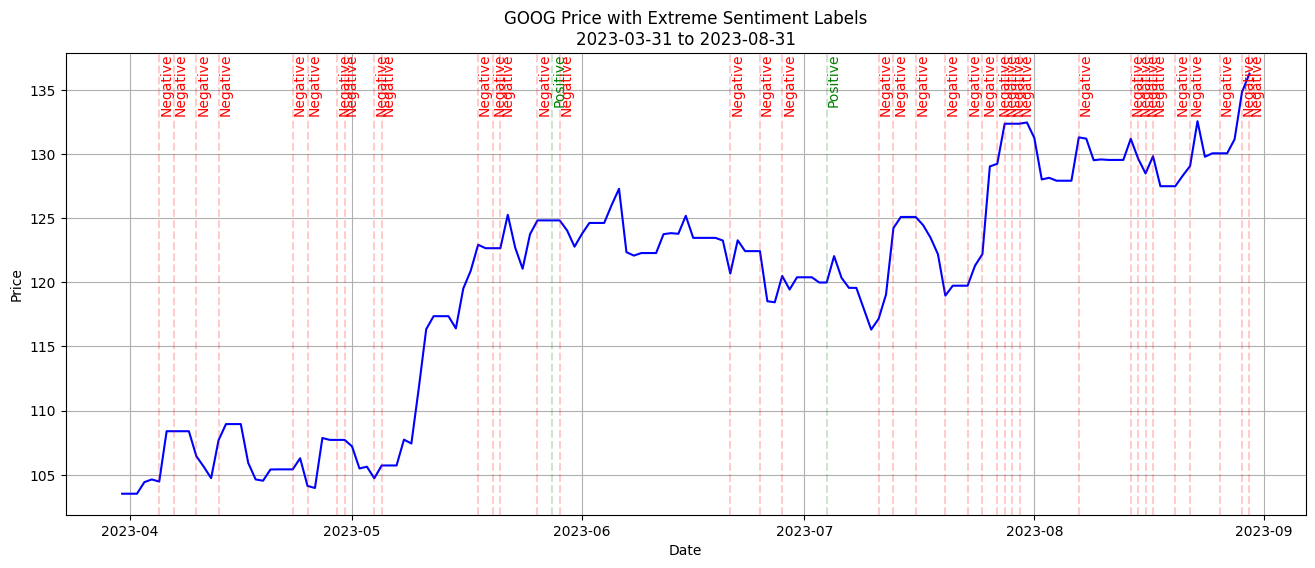

In [5]:
# === 5. Price with Extreme Sentiment Labels ===
goog_2020 = goog_df['2019-01-01':'2023-12-31'].copy()

# Filter for extreme sentiments (using 0.5 as threshold)
extreme_sentiment_mask = (goog_2020['daily_sentiment'].abs() >= 0.3)
goog_2020_extreme = goog_2020[extreme_sentiment_mask]

# Create sentiment labels
sentiment_labels = ['Positive' if s >= 0.7 else 'Negative' for s in goog_2020_extreme['daily_sentiment']]

# Split data into 5-month chunks
date_ranges = pd.date_range(start=goog_2020.index.min(), 
                          end=goog_2020.index.max(),
                          freq='5M')

# Plot each chunk
for i in range(len(date_ranges)-1):
    start_date = date_ranges[i]
    end_date = date_ranges[i+1]
    
    # Filter data for current chunk
    mask = (goog_2020.index >= start_date) & (goog_2020.index < end_date)
    chunk_data = goog_2020[mask]
    
    extreme_mask = (goog_2020_extreme.index >= start_date) & (goog_2020_extreme.index < end_date)
    chunk_extreme = goog_2020_extreme[extreme_mask]
    chunk_labels = [l for d, l in zip(goog_2020_extreme.index, sentiment_labels) if d >= start_date and d < end_date]

    # Create plot for chunk
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot price line
    ax.plot(chunk_data['adj_close'], label='Adj Close', color='blue')
    
    # Plot sentiment labels
    for date, label in zip(chunk_extreme.index, chunk_labels):
        color = 'green' if label == 'Positive' else 'red'
        ax.axvline(x=date, color=color, alpha=0.2, linestyle='--')
        ax.text(date, ax.get_ylim()[1], label,
                rotation=90,
                verticalalignment='top', 
                color=color)
    
    # Customize plot
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.title(f"GOOG Price with Extreme Sentiment Labels\n{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    plt.grid(True)
    plt.show()


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_14083/2718682885.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_ranges = pd.date_range(start=goog_df.index.min(),


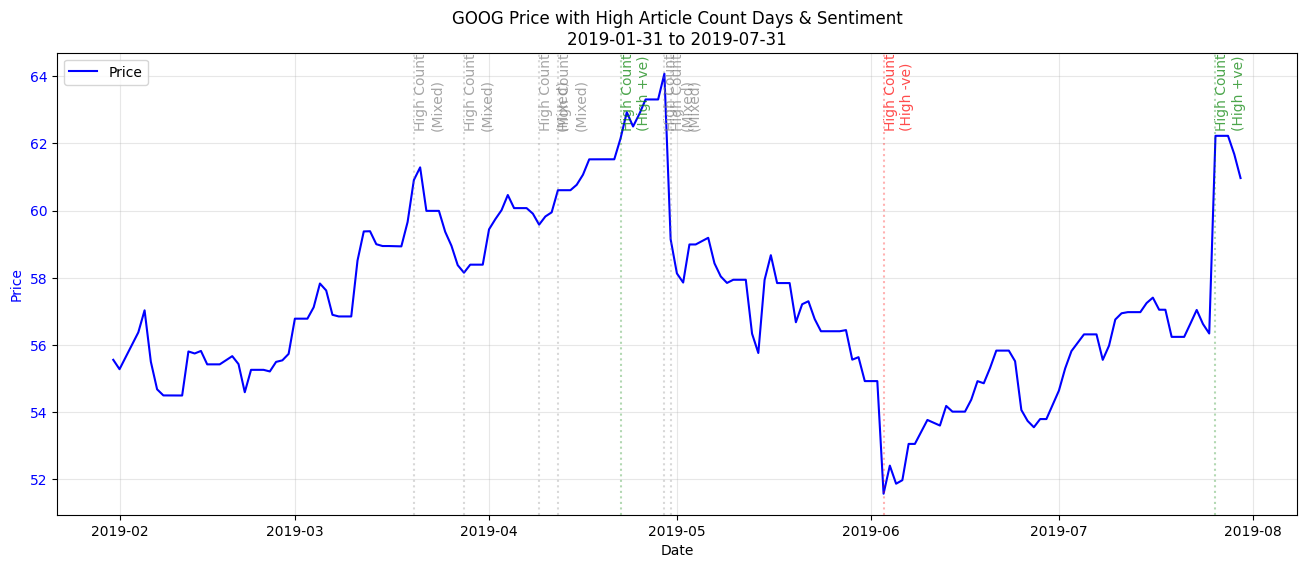

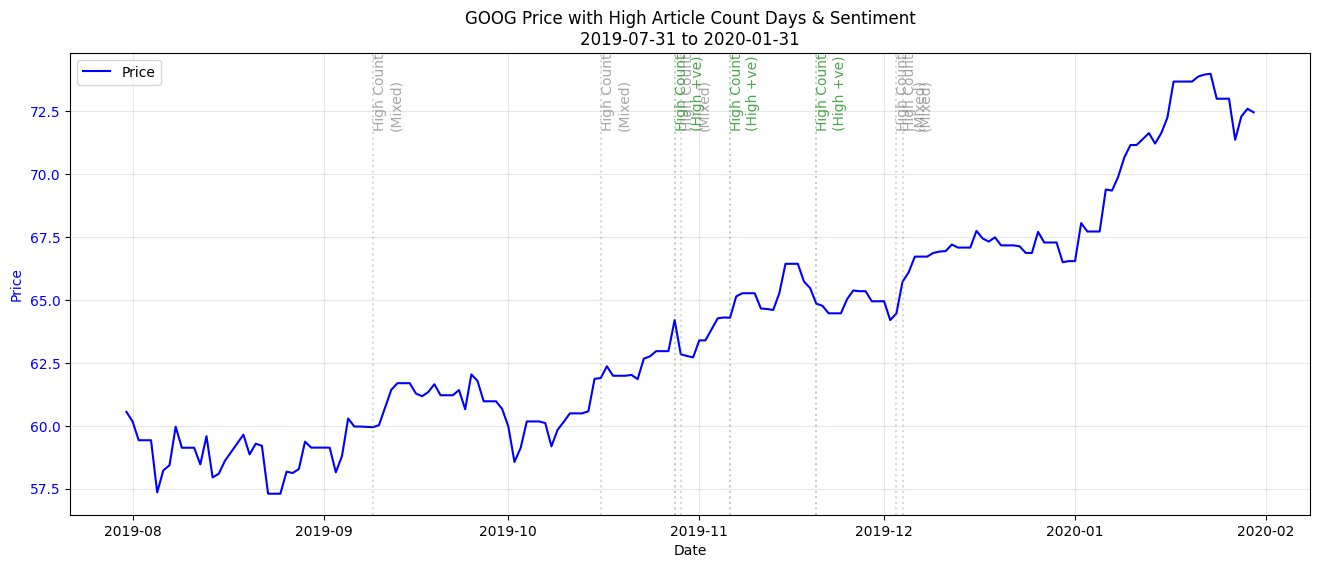

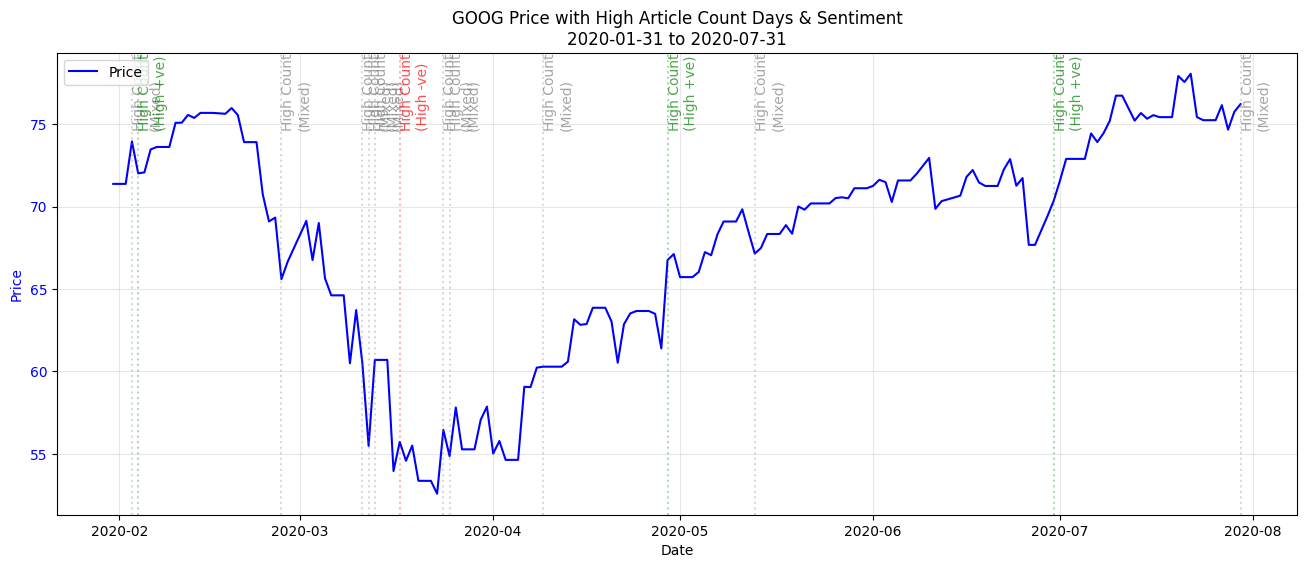

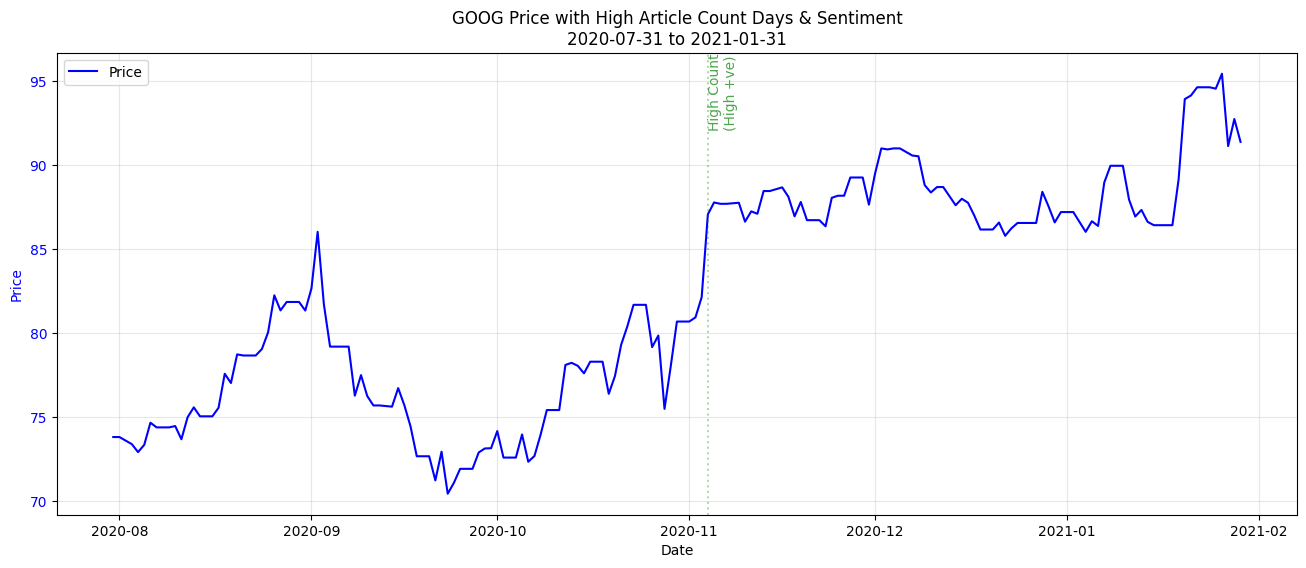

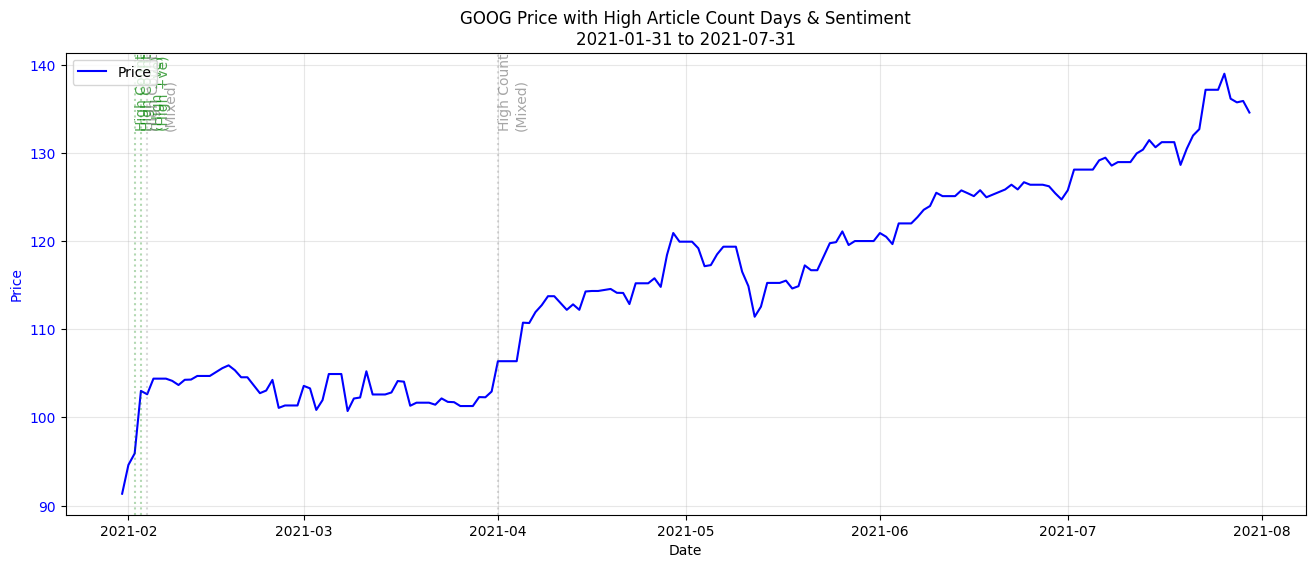

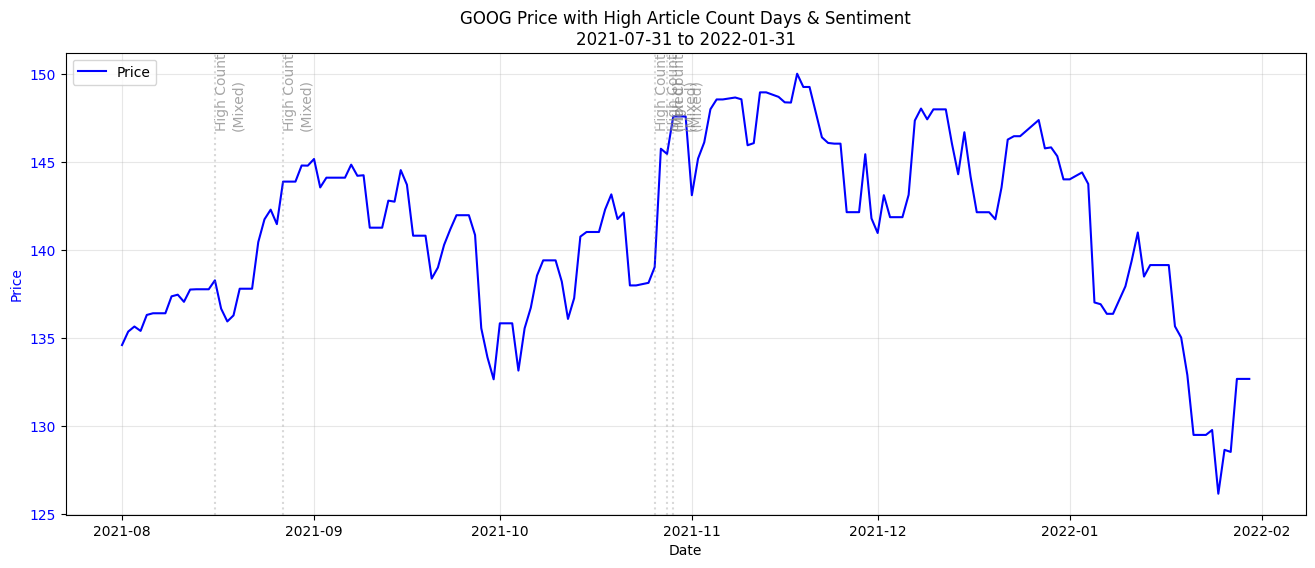

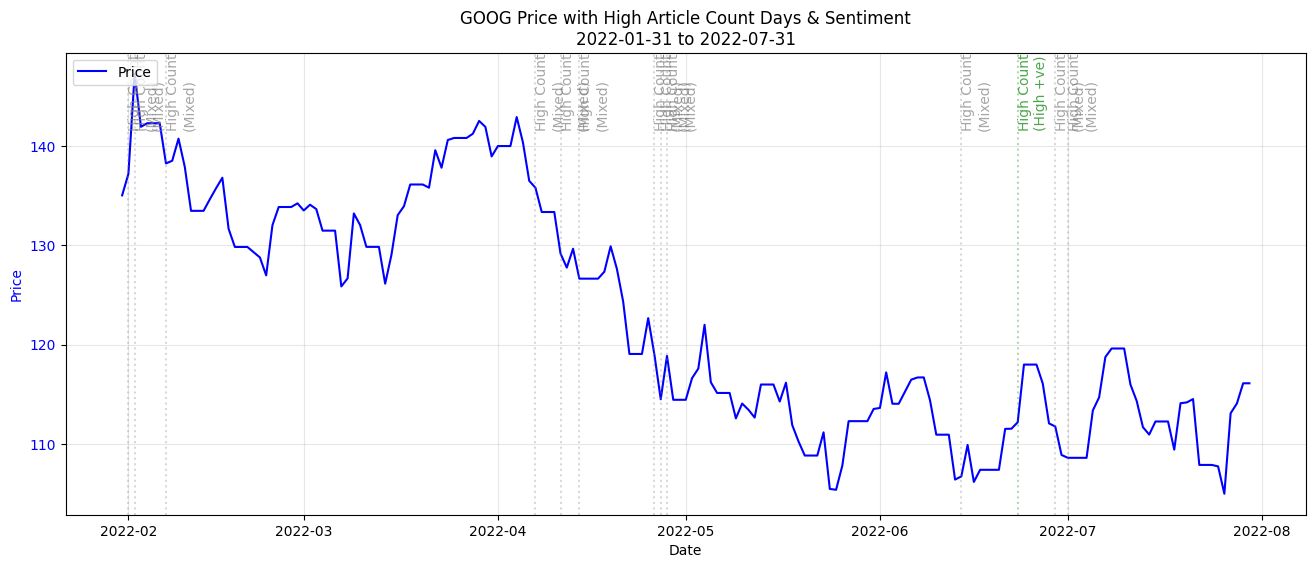

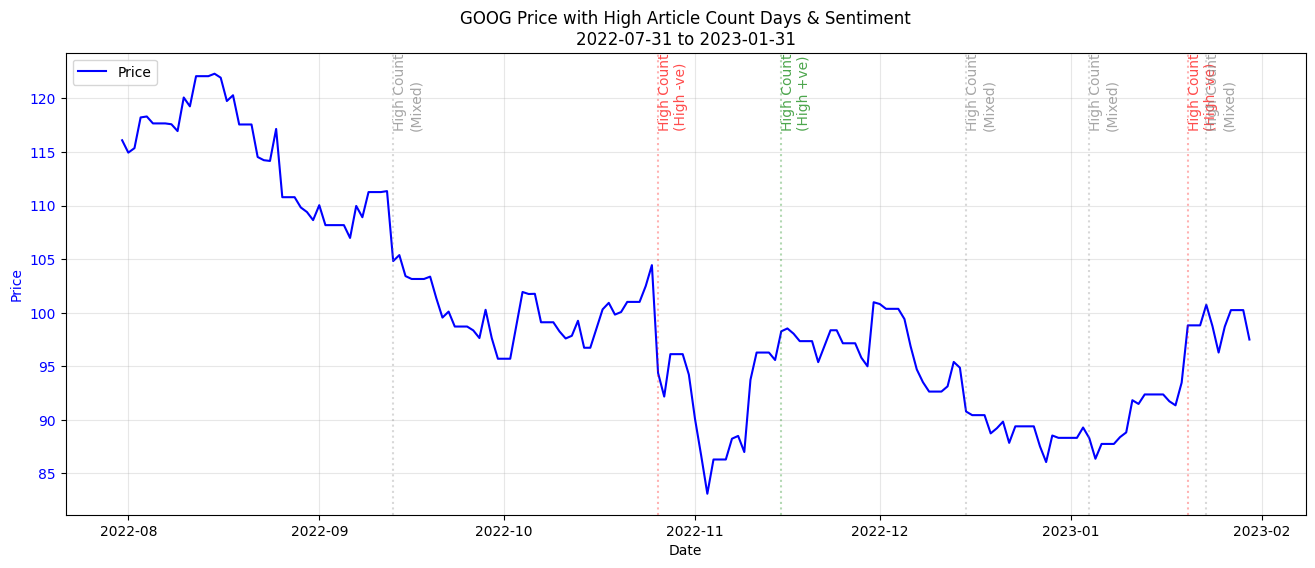

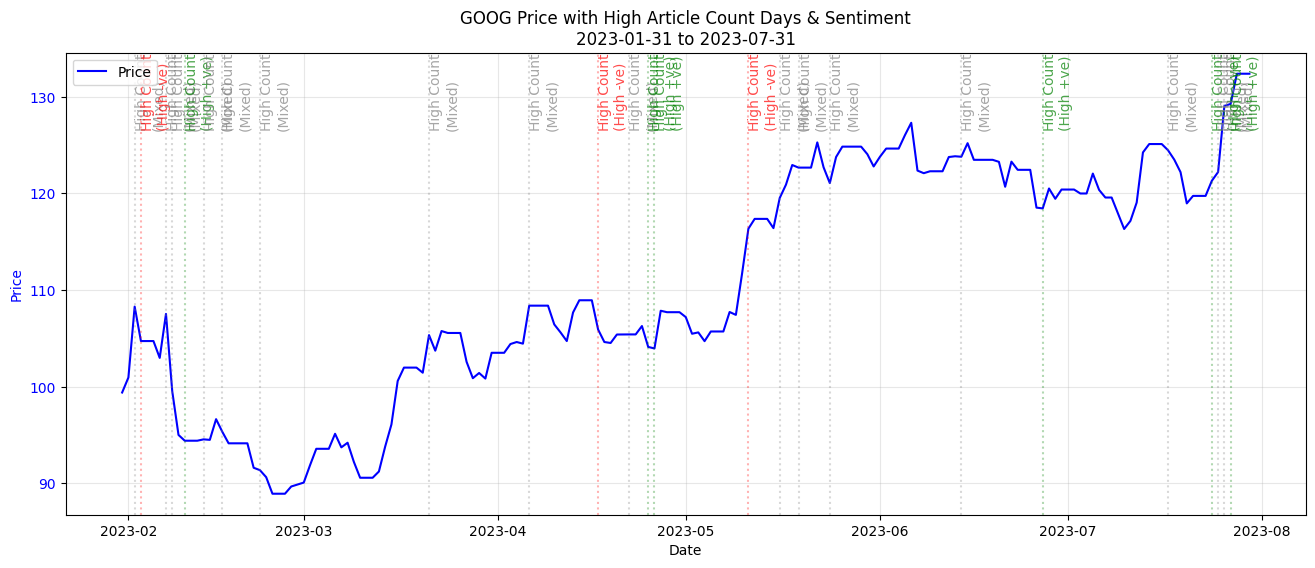

In [6]:
# === Plot Article Count vs Price Over Time with Sentiment Ratios ===
# Filter for high article count and get sentiment ratios
high_activity_df = goog_df[goog_df['article_count'] > 10].copy()

# Define thresholds for positive and negative ratios
POS_THRESHOLD = 0.5  # 60% positive sentiment
NEG_THRESHOLD = 0.5  # 60% negative sentiment

# Create 6-month date ranges
date_ranges = pd.date_range(start=goog_df.index.min(),
                          end=goog_df.index.max(), 
                          freq='6M')

# Plot each 6-month period separately
for i in range(len(date_ranges)-1):
    start_date = date_ranges[i]
    end_date = date_ranges[i+1]
    
    # Filter data for current 6-month period
    mask = (goog_df.index >= start_date) & (goog_df.index < end_date)
    period_data = goog_df[mask]
    
    high_activity_mask = (high_activity_df.index >= start_date) & (high_activity_df.index < end_date)
    period_high_activity = high_activity_df[high_activity_mask]

    # Create plot for 6-month period
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Plot price line for full period
    ax1.plot(period_data.index, period_data['adj_close'], color='blue', label='Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Add vertical lines and labels for high article count days
    for date in period_high_activity.index:
        row = period_high_activity.loc[date]
        
        # Determine color and label based on sentiment ratios
        if row['positive_ratio'] >= POS_THRESHOLD:
            color = 'green'
            label = 'High +ve'
        elif row['negative_ratio'] >= NEG_THRESHOLD:
            color = 'red'
            label = 'High -ve'
        else:
            color = 'gray'
            label = 'Mixed'
            
        ax1.axvline(x=date, color=color, linestyle=':', alpha=0.3)
        ax1.text(date, ax1.get_ylim()[1], f'High Count\n({label})',
                rotation=90,
                verticalalignment='top',
                color=color,
                alpha=0.7)

    # Add title and grid
    plt.title(f'GOOG Price with High Article Count Days & Sentiment\n{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
    ax1.grid(True, alpha=0.3)

    # Add legend
    ax1.legend(loc='upper left')

    plt.show()


High article count + high positive ratio leads to price increase.

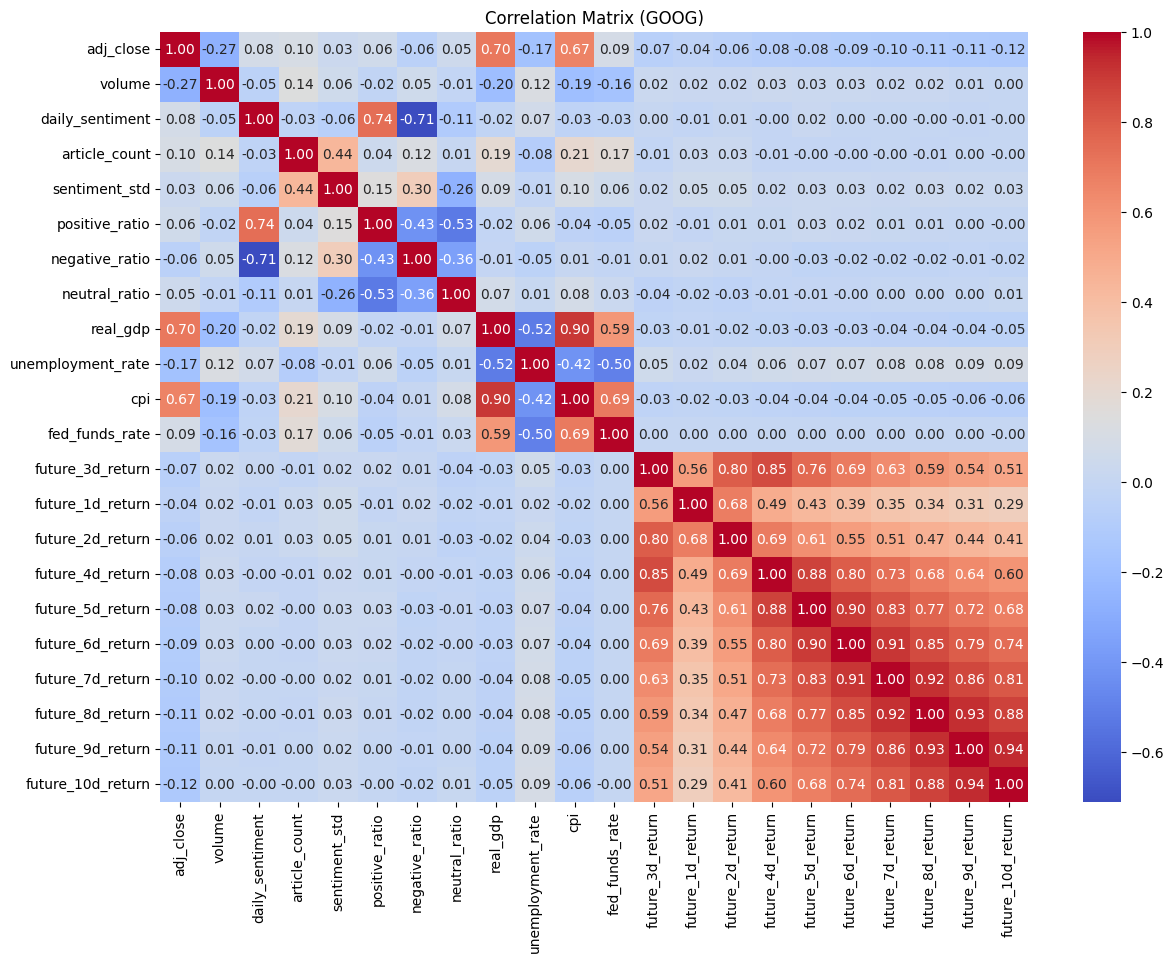

In [8]:
# === 2. Correlation Heatmap ===
plt.figure(figsize=(14, 10))
numeric_cols = goog_df.select_dtypes(include=[np.number]).columns
sns.heatmap(goog_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (GOOG)')
plt.show()

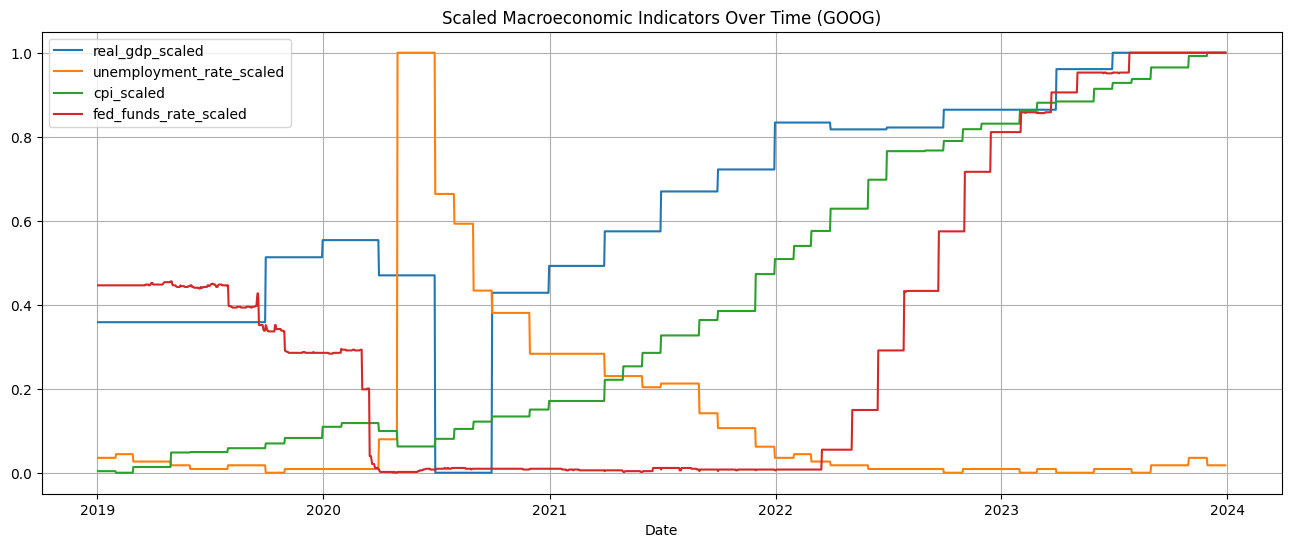

In [9]:
# === 3. Macro Feature Distributions ===
macro_features = ['real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate']

# === Scaling macro features for time series comparison ===
scaler = MinMaxScaler()
macro_scaled = pd.DataFrame(scaler.fit_transform(goog_df[macro_features]), 
                            columns=[f"{col}_scaled" for col in macro_features], 
                            index=goog_df.index)

# Concatenate scaled features with original dataframe if needed
goog_df_scaled = pd.concat([goog_df, macro_scaled], axis=1)

# === Plot Scaled Macros Over Time ===
plt.figure(figsize=(16, 6))
for col in macro_scaled.columns:
    plt.plot(macro_scaled.index, macro_scaled[col], label=col)
plt.legend()
plt.title('Scaled Macroeconomic Indicators Over Time (GOOG)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

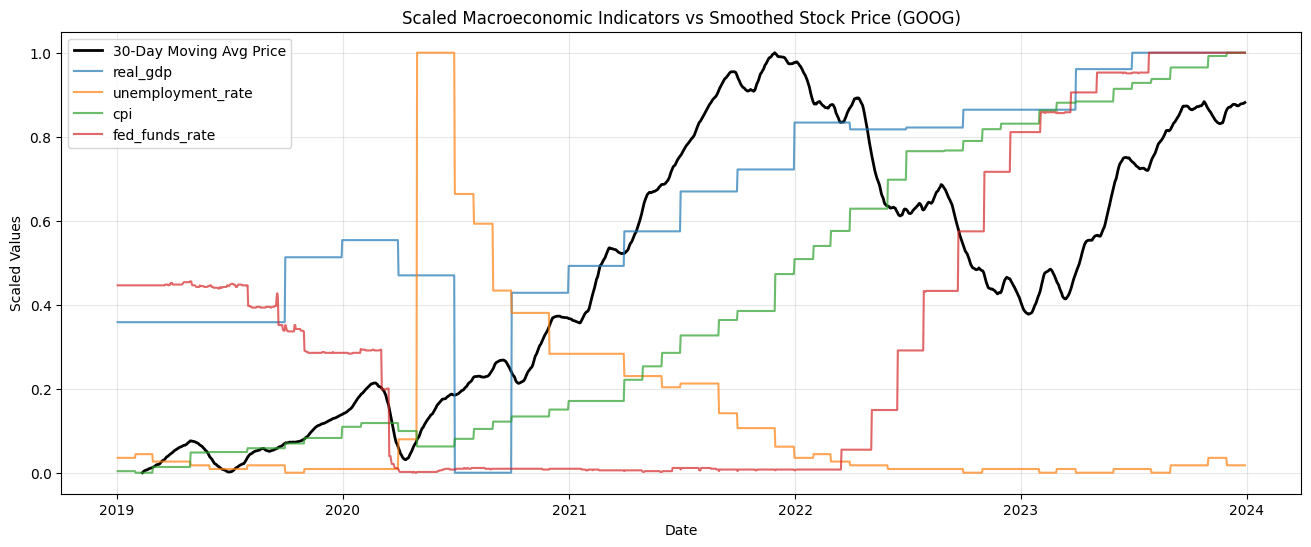

In [10]:
# === 3. Macro Features vs Smoothed Price ===
macro_features = ['real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate']

# Calculate smoothed price using 30-day rolling average
smoothed_price = goog_df['adj_close'].rolling(window=30).mean()

# Scale both macro features and smoothed price to same range
scaler = MinMaxScaler()
data_to_scale = pd.concat([goog_df[macro_features], smoothed_price], axis=1)
scaled_data = pd.DataFrame(
    scaler.fit_transform(data_to_scale),
    columns=[*macro_features, 'smoothed_price'],
    index=goog_df.index
)

# Plot macro features against smoothed price
plt.figure(figsize=(16, 6))
plt.plot(scaled_data.index, scaled_data['smoothed_price'], 
         label='30-Day Moving Avg Price', linewidth=2, color='black')
for feature in macro_features:
    plt.plot(scaled_data.index, scaled_data[feature], 
             label=feature, alpha=0.7)
plt.legend()
plt.title('Scaled Macroeconomic Indicators vs Smoothed Stock Price (GOOG)')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.grid(True, alpha=0.3)
plt.show()

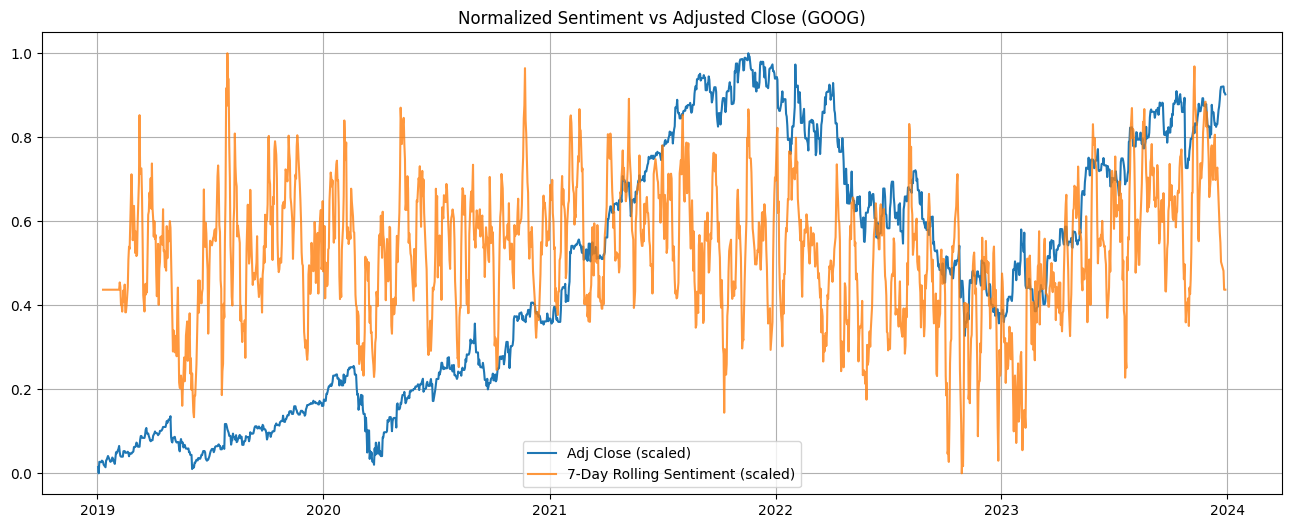

In [11]:
# === 4. Sentiment vs. 1-Day Future Return ===
goog_df['future_1d_return'] = goog_df['adj_close'].shift(-1) / goog_df['adj_close'] - 1

# Apply smoothing to daily sentiment using 7-day rolling average
goog_df['daily_sentiment_smooth'] = goog_df['daily_sentiment'].rolling(window=7).mean()

# Normalized overlay of sentiment and adj_close 
scaler = MinMaxScaler()
scaled = scaler.fit_transform(goog_df[['adj_close', 'daily_sentiment_smooth']])
goog_df['adj_close_scaled'] = scaled[:, 0]
goog_df['sentiment_scaled'] = scaled[:, 1]

plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close_scaled'], label='Adj Close (scaled)')
plt.plot(goog_df['sentiment_scaled'], label='7-Day Rolling Sentiment (scaled)', alpha=0.8)
plt.title("Normalized Sentiment vs Adjusted Close (GOOG)")
plt.legend()
plt.grid(True)
plt.show()


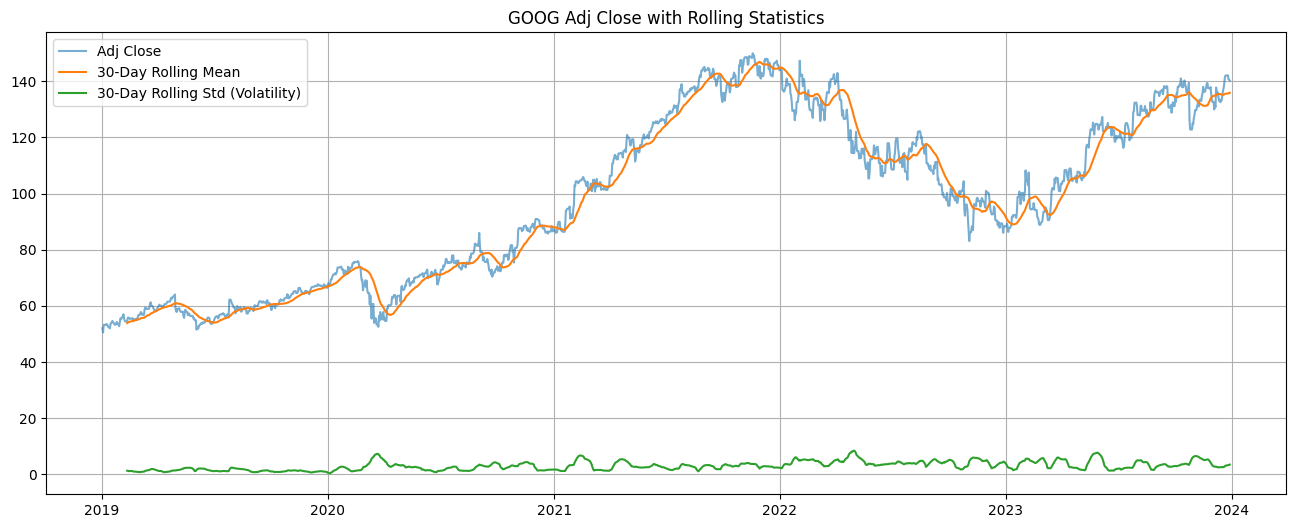

In [12]:
# === 5. Rolling Statistics ===
goog_df['rolling_mean_30'] = goog_df['adj_close'].rolling(window=30).mean()
goog_df['rolling_std_30'] = goog_df['adj_close'].rolling(window=30).std()

plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close'], label='Adj Close', alpha=0.6)
plt.plot(goog_df['rolling_mean_30'], label='30-Day Rolling Mean')
plt.plot(goog_df['rolling_std_30'], label='30-Day Rolling Std (Volatility)')
plt.title('GOOG Adj Close with Rolling Statistics')
plt.legend()
plt.grid(True)
plt.show()



# Feature Engineering

In [13]:
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final.columns

Index(['date', 'stock_symbol', 'open_price', 'high_price', 'low_price',
       'close_price', 'adj_close', 'volume', 'daily_sentiment',
       'article_count', 'sentiment_std', 'positive_ratio', 'negative_ratio',
       'neutral_ratio', 'sentiment_median', 'sentiment_min', 'sentiment_max',
       'sentiment_range', 'gdp', 'real_gdp', 'unemployment_rate', 'cpi',
       'fed_funds_rate', 'sp500'],
      dtype='object')

In [14]:
goog_df_final.head()

date stock_symbol  open_price  high_price  low_price  close_price  \
10417 2019-01-02         GOOG   50.828499   52.616001  50.785500    52.292500   
10418 2019-01-03         GOOG   52.049999   52.848999  50.703499    50.803001   
10419 2019-01-04         GOOG   51.629501   53.542000  51.370899    53.535500   
10420 2019-01-07         GOOG   53.575001   53.700001  52.737999    53.419498   
10421 2019-01-08         GOOG   53.805500   54.228001  53.026501    53.813999   

       adj_close    volume  daily_sentiment  article_count  ...  \
10417  52.045986  30652000              0.0              0  ...   
10418  50.563507  36822000              0.0              0  ...   
10419  53.283127  41878000              0.0              0  ...   
10420  53.167671  39638000              0.0              0  ...   
10421  53.560310  35298000              0.0              0  ...   

       sentiment_median  sentiment_min  sentiment_max  sentiment_range  \
10417               0.0            0.0            0.0              0.0   
10418               0.0            0.0            0.0              0.0   
10419               0.0            0.0            0.0              0.0   
10420               0.0            0.0            0.0              0.0   
10421               0.0            0.0            0.0              0.0   

             gdp   real_gdp  unemployment_rate      cpi  fed_funds_rate  \
10417  20917.867  20304.874                3.9  252.767             2.4   
10418  20917.867  20304.874                3.9  252.767             2.4   
10419  20917.867  20304.874                3.9  252.767             2.4   
10420  20917.867  20304.874                3.9  252.767             2.4   
10421  20917.867  20304.874                3.9  252.767             2.4   

         sp500  
10417  2510.03  
10418  2447.89  
10419  2531.94  
10420  2549.69  
10421  2574.41  

[5 rows x 24 columns]

In [15]:
# === Step 0: Create safe feature-engineered dataframe ===
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final['date'] = pd.to_datetime(goog_df_final['date'])
goog_df_final.sort_values('date', inplace=True)

# Create target (1-day future price)
forecast_horizon = 1
goog_df_final['adj_close_future_1d'] = goog_df_final['adj_close'].shift(-forecast_horizon)

# === Safe Feature Engineering ===
# 1. Lagged Features
lag_periods = [1, 2, 3, 5, 7]
for feature in ['adj_close', 'volume', 'daily_sentiment']:
    for lag in lag_periods:
        goog_df_final[f'{feature}_lag_{lag}'] = goog_df_final[feature].shift(lag)

# 2. Volume Change Features (Added)
goog_df_final['volume_change_1d'] = goog_df_final['volume'].pct_change().shift(1)
goog_df_final['volume_change_3d'] = goog_df_final['volume'].pct_change(3).shift(1)
goog_df_final['volume_change_7d'] = goog_df_final['volume'].pct_change(7).shift(1)

# 3. Rolling Statistics (Past-Only)
for feature in ['adj_close', 'volume', 'daily_sentiment']:
    for window in [3, 7, 14]:
        rolled = goog_df_final[feature].shift(1).rolling(window=window, min_periods=1)
        goog_df_final[f'{feature}_rollmean_{window}'] = rolled.mean()
        goog_df_final[f'{feature}_rollstd_{window}'] = rolled.std()

# 4. Momentum Indicators (Past-Only)
goog_df_final['past_1d_return'] = goog_df_final['adj_close'].pct_change(periods=1)
goog_df_final['past_3d_return'] = goog_df_final['adj_close'].pct_change(periods=3)
goog_df_final['past_7d_return'] = goog_df_final['adj_close'].pct_change(periods=7)

# 5. Volatility Features
goog_df_final['prev_close'] = goog_df_final['adj_close'].shift(1)
goog_df_final['true_range'] = goog_df_final.apply(
    lambda x: max(x['high_price']-x['low_price'],
                abs(x['high_price']-x['prev_close']),
                abs(x['low_price']-x['prev_close'])), axis=1)
goog_df_final['atr_7d'] = goog_df_final['true_range'].rolling(7).mean().shift(1)

# 6. Time Features
goog_df_final['day_of_week'] = goog_df_final['date'].dt.dayofweek
goog_df_final['month'] = goog_df_final['date'].dt.month
goog_df_final = pd.get_dummies(goog_df_final, columns=['day_of_week', 'month'], drop_first=True)
goog_df_final.dropna(inplace=True)

# === Step 1: Define columns to drop ===
explicit_drops = [
    'stock_symbol', 'open_price', 'high_price', 'low_price',
    'close_price', 'prev_close', 'true_range', 'sp500', 'gdp'
]

# === Step 3: Time-based Split ===
train_end = '2022-12-31'
val_end = '2023-06-30'

train_df = goog_df_final[goog_df_final['date'] <= train_end].copy()
val_df = goog_df_final[(goog_df_final['date'] > train_end) & (goog_df_final['date'] <= val_end)].copy()
test_df = goog_df_final[goog_df_final['date'] > val_end].copy()

# === Step 4: Drop unwanted columns ===
train_df = train_df.drop(columns=explicit_drops, errors='ignore')
val_df = val_df.drop(columns=explicit_drops, errors='ignore')
test_df = test_df.drop(columns=explicit_drops, errors='ignore')

# === Step 5: Define target and features ===
target_col = 'adj_close_future_1d'
feature_cols = [col for col in train_df.columns if col not in [target_col, 'date']]

# === Step 6: Extract features and target ===
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_val, y_val = val_df[feature_cols], val_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# === Step 7: Scale numeric columns ===
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)  


Number of features: 73
Sample features: ['adj_close', 'volume', 'daily_sentiment', 'article_count', 'sentiment_std', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'sentiment_median', 'sentiment_min', 'sentiment_max', 'sentiment_range', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'adj_close_lag_1', 'adj_close_lag_2', 'adj_close_lag_3', 'adj_close_lag_5', 'adj_close_lag_7', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3', 'volume_lag_5', 'volume_lag_7', 'daily_sentiment_lag_1', 'daily_sentiment_lag_2', 'daily_sentiment_lag_3', 'daily_sentiment_lag_5', 'daily_sentiment_lag_7', 'volume_change_1d', 'volume_change_3d', 'volume_change_7d', 'adj_close_rollmean_3', 'adj_close_rollstd_3', 'adj_close_rollmean_7', 'adj_close_rollstd_7', 'adj_close_rollmean_14', 'adj_close_rollstd_14', 'volume_rollmean_3', 'volume_rollstd_3', 'volume_rollmean_7', 'volume_rollstd_7', 'volume_rollmean_14', 'volume_rollstd_14', 'daily_sentiment_rollmean_3', 'daily_sentiment_rollstd_3', 'daily_sent

1. lagged versions of key features to help the model understand historical context:
	•	adj_close_lag_X: Closing price X days ago.
	•	volume_lag_X: Volume X days ago.
	•	article_sentiment_lag_X: Sentiment score X days ago.
These provide temporal patterns—i.e., how previous values relate to future prices.

2. percentage changes in volume:
	•	volume_change_1d: Yesterday’s volume change.
	•	volume_change_3d: Volume change over 3 days (ending yesterday).
	•	volume_change_7d: Volume change over 7 days (ending yesterday).
Why useful? Sudden volume changes often precede large price movements or volatility spikes.

3. moving averages and volatility indicators:
	•	*_rollmean_X: Rolling average over past X days (excluding today).
	•	*_rollstd_X: Rolling standard deviation over past X days (excluding today).
Rolling mean captures trend; rolling std captures volatility.

4. returns over different time horizons:
	•	past_1d_return: Daily return.
	•	past_3d_return: Return over past 3 days.
	•	past_7d_return: Return over past week.
Captures recent price momentum—essential for trend-following strategies.

5. Average True Range (ATR), a standard volatility indicator:
	•	true_range: Measures the most extreme price movement including gaps.
	•	atr_7d: 7-day average of true_range (ATR over 7 days).
High ATR → high volatility → possible market moves or reversals.

6. Time features
	•	day_of_week: From 0 (Monday) to 6 (Sunday) → one-hot encoded.
	•	month: Month number → one-hot encoded.
Helps capture weekly/monthly seasonality in stock behavior (e.g., “Monday effect”).

7. Target: adj_close_future_3d: Target for regression

In [16]:
X_train_scaled.head()

adj_close    volume  daily_sentiment  article_count  sentiment_std  \
10425  -1.393902 -0.554193        -0.230039      -1.574916      -1.519541   
10426  -1.340231 -0.074266        -0.230039      -1.574916      -1.519541   
10427  -1.333915 -0.272369        -0.230039      -1.574916      -1.519541   
10428  -1.319150 -0.406292        -0.230039      -1.574916      -1.519541   
10429  -1.305327  0.665241        -0.230039      -1.574916      -1.519541   

       positive_ratio  negative_ratio  neutral_ratio  sentiment_median  \
10425       -1.346984       -0.974002      -1.169616         -0.239929   
10426       -1.346984       -0.974002      -1.169616         -0.239929   
10427       -1.346984       -0.974002      -1.169616         -0.239929   
10428       -1.346984       -0.974002      -1.169616         -0.239929   
10429       -1.346984       -0.974002      -1.169616         -0.239929   

       sentiment_min  ...  month_3  month_4  month_5  month_6  month_7  \
10425       0.819177  ...    False    False    False    False    False   
10426       0.819177  ...    False    False    False    False    False   
10427       0.819177  ...    False    False    False    False    False   
10428       0.819177  ...    False    False    False    False    False   
10429       0.819177  ...    False    False    False    False    False   

       month_8  month_9  month_10  month_11  month_12  
10425    False    False     False     False     False  
10426    False    False     False     False     False  
10427    False    False     False     False     False  
10428    False    False     False     False     False  
10429    False    False     False     False     False  

[5 rows x 73 columns]

In [17]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1367 entries, 10425 to 13361
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   adj_close                    1367 non-null   float64
 1   volume                       1367 non-null   float64
 2   daily_sentiment              1367 non-null   float64
 3   article_count                1367 non-null   float64
 4   sentiment_std                1367 non-null   float64
 5   positive_ratio               1367 non-null   float64
 6   negative_ratio               1367 non-null   float64
 7   neutral_ratio                1367 non-null   float64
 8   sentiment_median             1367 non-null   float64
 9   sentiment_min                1367 non-null   float64
 10  sentiment_max                1367 non-null   float64
 11  sentiment_range              1367 non-null   float64
 12  real_gdp                     1367 non-null   float64
 13  unemployment_rate 

# Baseline model

Linear Regression - MAE: 1.45, RMSE: 2.04, R²: 0.9709
Random Forest - MAE: 1.88, RMSE: 2.47, R²: 0.9573
Linear Regression - Directional Accuracy: 59.44%
Random Forest - Directional Accuracy: 56.11%


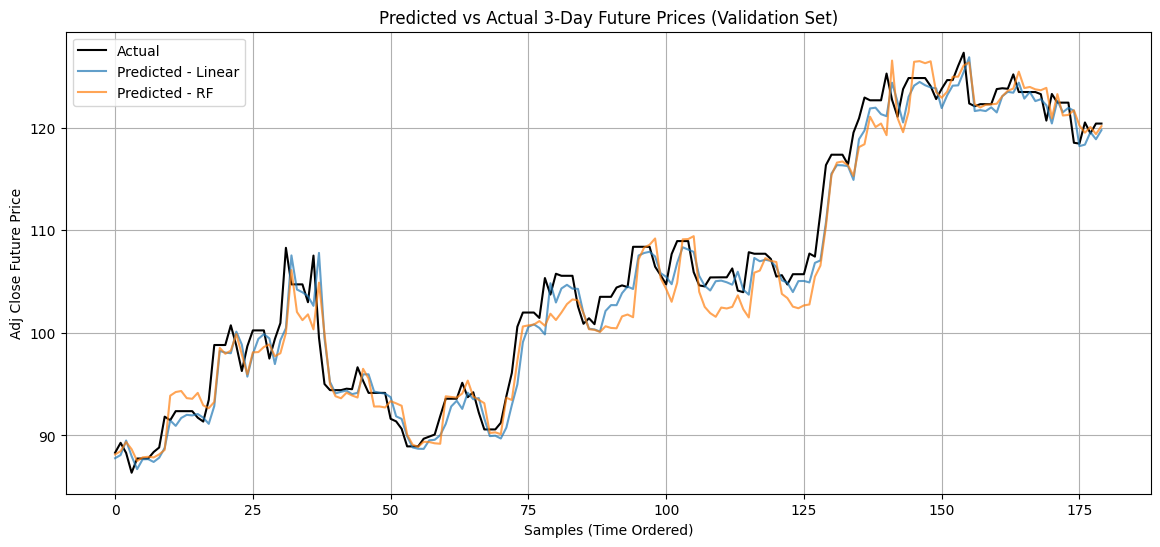

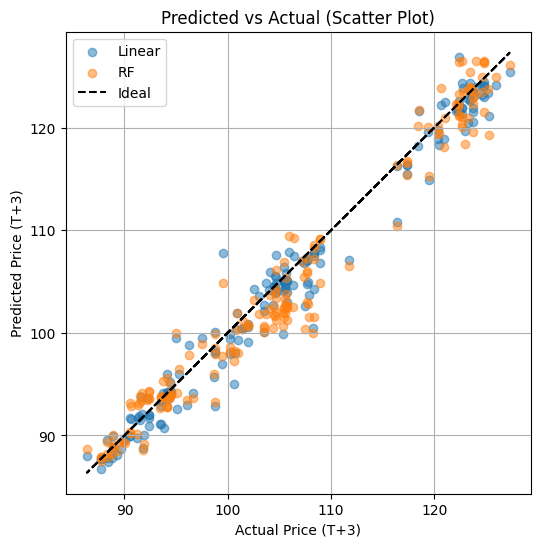

In [18]:
# === Step 1: Train Linear Regression and Random Forest ===
linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

linreg.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# === Step 2: Predict on validation set ===
y_val_pred_linreg = linreg.predict(X_val_scaled)
y_val_pred_rf = rf.predict(X_val_scaled)

# === Step 3: Evaluation Metrics ===
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return mae, rmse, r2

evaluate_model(y_val, y_val_pred_linreg, "Linear Regression")
evaluate_model(y_val, y_val_pred_rf, "Random Forest")

# === Step 4: Directional Accuracy (based on predicted vs actual return direction) ===
# Calculate actual 3-day return direction
actual_return = y_val.values - X_val['adj_close_lag_1'].values
pred_linreg_return = y_val_pred_linreg - X_val['adj_close_lag_1'].values
pred_rf_return = y_val_pred_rf - X_val['adj_close_lag_1'].values

dir_acc_linreg = np.mean(np.sign(actual_return) == np.sign(pred_linreg_return))
dir_acc_rf = np.mean(np.sign(actual_return) == np.sign(pred_rf_return))

print(f"Linear Regression - Directional Accuracy: {dir_acc_linreg:.2%}")
print(f"Random Forest - Directional Accuracy: {dir_acc_rf:.2%}")

# === Step 6: Visualization - Actual vs Predicted over time ===
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual', color='black')
plt.plot(y_val_pred_linreg, label='Predicted - Linear', alpha=0.7)
plt.plot(y_val_pred_rf, label='Predicted - RF', alpha=0.7)
plt.title("Predicted vs Actual 1-Day Future Prices (Validation Set)")
plt.xlabel("Samples (Time Ordered)")
plt.ylabel("Adj Close Future Price")
plt.legend()
plt.grid(True)
plt.show()

# === Step 7: Scatter Plot - Predicted vs Actual ===
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred_linreg, label='Linear', alpha=0.5)
plt.scatter(y_val, y_val_pred_rf, label='RF', alpha=0.5)
plt.plot(y_val, y_val, color='black', linestyle='--', label='Ideal')
plt.xlabel("Actual Price (T+3)")
plt.ylabel("Predicted Price (T+3)")
plt.title("Predicted vs Actual (Scatter Plot)")
plt.legend()
plt.grid(True)
plt.show()

# Model Interpretability 

In [26]:
# === 1. Random Forest Feature Importance ===
rf_importances = rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Format to decimals (e.g., 0.000523 instead of 5.23e-04)
pd.options.display.float_format = '{:.6f}'.format

print("\nRandom Forest Feature Importances:")
print(rf_importance_df.to_string(index=False))

# === 2. Linear Regression Coefficients ===
linreg_coefs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

print("\nLinear Regression Coefficients:")
print(linreg_coefs.to_string(index=False))

# === 3. Select Top Features for Retraining ===
# Get top 10 features from Random Forest
top_rf_features = rf_importance_df.head(15)['Feature'].tolist()

# Get top 10 features from Linear Regression (by absolute coefficient value)
top_linreg_features = linreg_coefs.head(15)['Feature'].tolist()

# Combine unique features from both models
selected_features = list(set(top_rf_features + top_linreg_features))
print(f"\nSelected {len(selected_features)} features for model retraining:")
print(selected_features)

# Create datasets with selected features
X_train_sel = X_train_scaled[selected_features]
X_val_sel = X_val_scaled[selected_features] if 'X_val_scaled' in locals() else None
X_test_sel = X_test_scaled[selected_features]

print(f"\nReduced feature set shape: {X_train_sel.shape}")


Random Forest Feature Importances:
                    Feature  Importance
                  adj_close    0.947628
       adj_close_rollmean_3    0.026989
            adj_close_lag_1    0.020824
            adj_close_lag_2    0.001572
             fed_funds_rate    0.000383
      adj_close_rollmean_14    0.000121
 daily_sentiment_rollstd_14    0.000106
       adj_close_rollstd_14    0.000094
              article_count    0.000093
daily_sentiment_rollmean_14    0.000092
                     atr_7d    0.000074
       adj_close_rollmean_7    0.000074
          volume_rollstd_14    0.000073
 daily_sentiment_rollmean_7    0.000069
            adj_close_lag_5    0.000068
  daily_sentiment_rollstd_7    0.000067
      daily_sentiment_lag_7    0.000066
      daily_sentiment_lag_2    0.000065
         volume_rollmean_14    0.000065
            adj_close_lag_3    0.000061
 daily_sentiment_rollmean_3    0.000060
               volume_lag_5    0.000060
           volume_change_7d    0.000054
    


=== Test Set Evaluation ===
Linear Regression - MAE: 1.41, RMSE: 4.20, R²: 0.8799
Random Forest - MAE: 1.60, RMSE: 6.14, R²: 0.8243
Linear Regression - Directional Accuracy: 36.57%
Random Forest - Directional Accuracy: 36.57%
Naive Forecast (No Change) - MAE: 1.83, RMSE: 7.72, R²: 0.7792
Naive Forecast - Directional Accuracy: 27.43%


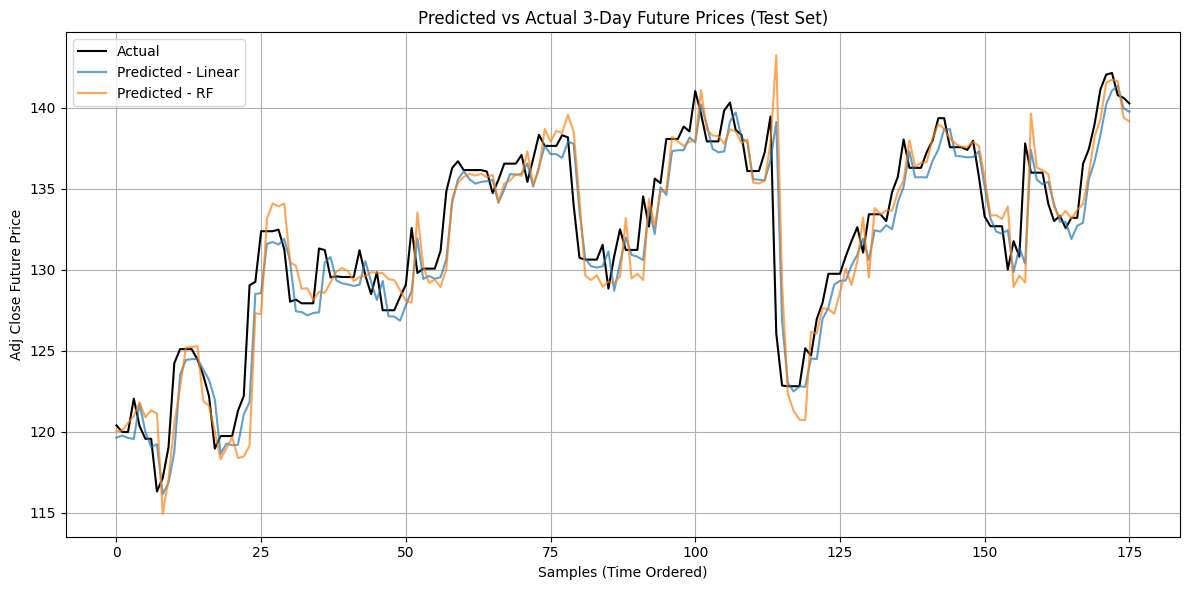

In [27]:
# Retrain models on selected features
linreg_sel = LinearRegression()
rf_sel = RandomForestRegressor(n_estimators=100, random_state=42)

linreg_sel.fit(X_train_sel, y_train)
rf_sel.fit(X_train_sel, y_train)

# === 1. Predict on Test Set ===
y_pred_lr_test_sel = linreg_sel.predict(X_test_sel)
y_pred_rf_test_sel = rf_sel.predict(X_test_sel)

# === 2. Evaluation Metrics ===
def evaluate(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return mae, rmse, r2

print("\n=== Test Set Evaluation ===")
evaluate(y_test, y_pred_lr_test_sel, name="Linear Regression")
evaluate(y_test, y_pred_rf_test_sel, name="Random Forest")

# === 3. Directional Accuracy ===
def directional_accuracy(y_true, y_pred, base=None):
    actual_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    accuracy = (actual_direction == pred_direction).mean() * 100
    return round(accuracy, 2)

print(f"Linear Regression - Directional Accuracy: {directional_accuracy(y_test.values, y_pred_lr_test_sel)}%")
print(f"Random Forest - Directional Accuracy: {directional_accuracy(y_test.values, y_pred_rf_test_sel)}%")

# === 4. Naive Baseline (No Change) ===
y_naive = X_test['adj_close_lag_1'].values  # naive: 3-day future price = today's price
evaluate(y_test, y_naive, name="Naive Forecast (No Change)")
print(f"Naive Forecast - Directional Accuracy: {directional_accuracy(y_test.values, y_naive)}%")

# === 5. Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_lr_test_sel, label='Predicted - Linear', alpha=0.7)
plt.plot(y_pred_rf_test_sel, label='Predicted - RF', alpha=0.7)
plt.title('Predicted vs Actual 3-Day Future Prices (Test Set)')
plt.xlabel('Samples (Time Ordered)')
plt.ylabel('Adj Close Future Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM 

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9799.0986 - mae: 94.3827 - val_loss: 10519.0605 - val_mae: 101.9614 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8258.5576 - mae: 85.9439 - val_loss: 7845.3555 - val_mae: 87.8370 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5735.6709 - mae: 69.6119 - val_loss: 5222.1182 - val_mae: 71.3654 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3963.4128 - mae: 55.0300 - val_loss: 3118.4053 - val_mae: 54.6746 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2462.4363 - mae: 39.7455 - val_loss: 1695.1536 - val_mae: 39.5735 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1588.0072 - mae: 31.7603 - val_loss: 911.0207 - val_mae: 27.9631 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1203.5710 - mae: 28.9174 - val_loss: 550.4298 - val

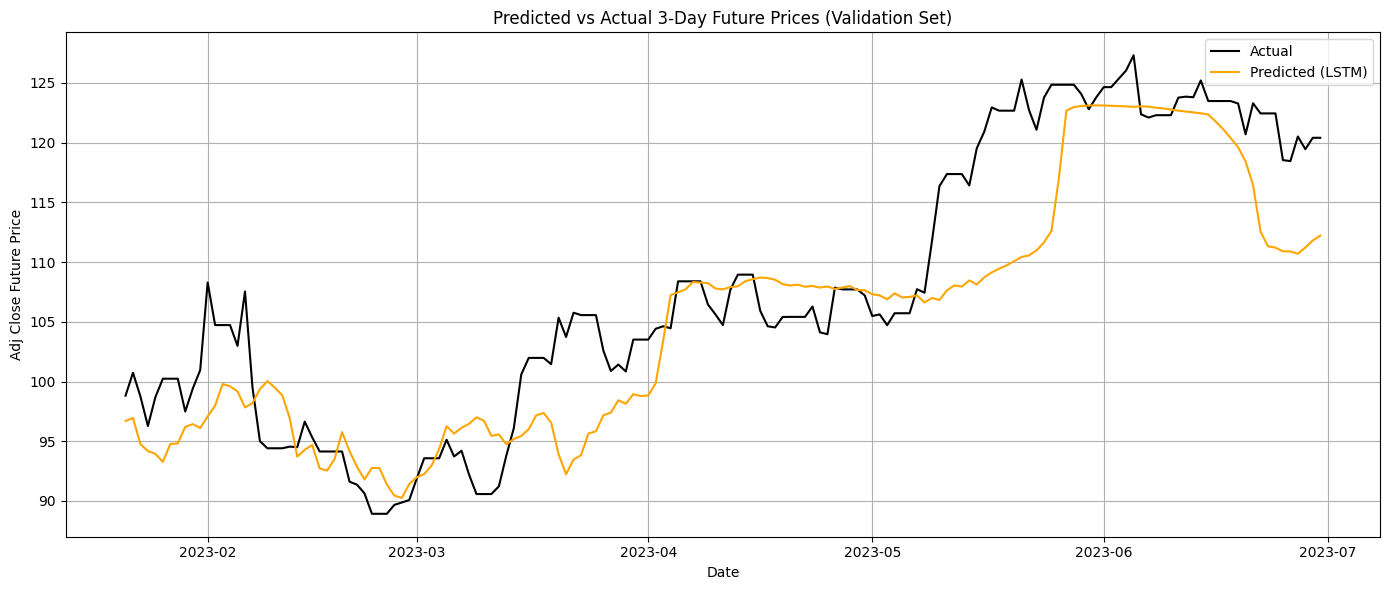

In [ ]:

# === PARAMETERS ===
LOOKBACK = 20  # Number of past days as input
BATCH_SIZE = 32
EPOCHS = 100

# === STEP 1: Recreate supervised learning sequences ===
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# === STEP 2: Scale features ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Ensure float32 for Keras compatibility
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# === STEP 3: Create LSTM input sequences ===
X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_train.values, LOOKBACK)
X_val_seq, y_val_seq = create_sequences(X_val_scaled.values, y_val.values, LOOKBACK)
X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_test.values, LOOKBACK)

# === STEP 4: Build the model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train_seq.shape[2]), dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# === STEP 5: Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === STEP 6: Evaluation ===
val_preds = model.predict(X_val_seq).flatten()
print("Validation MAE:", mean_absolute_error(y_val_seq, val_preds))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val_seq, val_preds)))
print("Validation R²:", r2_score(y_val_seq, val_preds))

# === STEP 7: Visualization ===
plot_df = val_df.iloc[LOOKBACK:].copy()
plot_df['Actual'] = y_val_seq
plot_df['Predicted'] = val_preds

plt.figure(figsize=(14, 6))
plt.plot(plot_df['date'], plot_df['Actual'], label='Actual', color='black')
plt.plot(plot_df['date'], plot_df['Predicted'], label='Predicted (LSTM)', color='orange')
plt.title('Predicted vs Actual 1-Day Future Prices (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Adj Close Future Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Why a Linear Model Might Outperform an LSTM (Short Horizon Challenges)

In short-term stock forecasting (e.g. predicting 3 days ahead), it’s not uncommon for a simple model (like linear regression or even a “no-change” random walk) to beat a complex LSTM. There are several reasons for this underperformance:
	•	Market Randomness: Financial price movements often resemble a random walk – past prices alone may carry little predictive signal for the near future ￼. If true, an LSTM trained only on historical prices is trying to find patterns that might not exist, while a linear model that essentially extrapolates the recent trend or assumes minimal change can perform just as well or better by not overfitting noise. As one analysis put it, if stock prices are essentially random and “historical information has no bearing on a stock’s future movement,” then “an LSTM using historical price movement to predict future ones” is fundamentally challenged ￼.
	•	High Variance vs. Low Variance: LSTMs are high-capacity models with many parameters. They can overfit small datasets, learning spurious patterns. A linear model has far fewer parameters and is less prone to overfitting on limited data. With only a few years of daily data (perhaps ~750–1000 trading days), a complex LSTM can easily memorize noise unless heavily regularized. Simpler models “need fewer data to converge” and may outperform a complex LSTM when data is limited ￼. In other words, the LSTM’s flexibility is an advantage only if sufficient data or true patterns exist – otherwise the linear model’s simplicity is a strength.
	•	Short-Term Dynamics: For very short horizons like 3 days ahead, there might be only modest linear autocorrelations (e.g. momentum or mean reversion) that a linear model can capture. LSTMs excel at learning complex nonlinear temporal dependencies, but if the target pattern is essentially linear or very weak, the LSTM may not have an edge. In fact, a well-tuned LSTM might end up approximating something close to the linear relationship anyway, but with more difficulty. Any slight mismatch can hurt accuracy.
	•	Training Difficulty: LSTMs require careful tuning (learning rate, architecture, etc.). If not optimized well, they might underperform a more straightforward method. For example, using an improper sequence length or suboptimal hyperparameters could hamper LSTM performance, giving an edge to a plug-and-play linear regression. We address these considerations below.

Despite these challenges, LSTMs can outperform linear models when properly utilized – numerous studies have found advanced LSTM-based models consistently beating linear methods for stock prediction ￼. The key is to mitigate overfitting and make the most of LSTM’s strengths. Below, we outline best practices to improve LSTM performance in short-horizon stock forecasting.